# pip installs

In [85]:
!pip install datasets
!pip install wordcloud
!pip install gensim nltk scikit-learn tqdm
!pip install glove-python-binary
!pip install OpenAI
!pip install tiktoken
!pip install xgboost
!pip install sentence-transformers



ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/113.8 MB 1.0 MB/s eta 0:01:48
   ---------------------------------------- 0.8/113.8 MB 1.1 MB/s eta 0:01:42
   ---------------------------------------- 1.0/113.8 MB 1.2 MB/s eta 0:01:32
    --------------------------------------- 1.6/113.8 MB 1.4 MB/s eta 0:01:23
    --------------------------------------- 1.8/113.8 MB 1.4 MB/s eta 0:01:19
    --------------------------------------- 2.4/113.8 MB 1.5 MB/s eta 0:01:13
   - -------------------------------------- 2.9/113.8 MB 1.7 MB/s eta 0:01:07
   - -------------------------------------- 3.4/113.8 MB 1.8 MB/s eta 0:01:03
   - -------------------------------------- 4.2/113.8 MB 1.9 MB/s eta 0:00:57
   - -------------------------------------- 4.7/113.8 MB 2.0 MB/s eta 0:00:54
   - --

# imports


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import math
import matplotlib.pyplot as plt
import re
import string
from matplotlib.patches import Patch
import nltk
from nltk import pos_tag, word_tokenize,pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from openai import OpenAI
import pandas as pd
import time
import os
import asyncio
import aiohttp
from openai import AsyncOpenAI
import nest_asyncio
import tiktoken
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import requests
import difflib
from sklearn.base import BaseEstimator



# downlodes

In [51]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Us

True

# DATA creation

In [36]:
new_dataset = load_dataset("dmitva/human_ai_generated_text")
new_data = new_dataset["train"].to_pandas()
new_data.head()

KeyboardInterrupt: 

In [ ]:
new_data= new_data[['human_text','instructions']]
new_data

,human_text,instructions
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...
4,Many people around the world have different ch...,Task: Research and discuss how character trait...
...,...,...
999995,You can meet up with your family at the park. ...,Task: Research reasons why people might find c...
999996,Even small chores prepare us for something big...,Task: \n\n1. Research the history of the US an...
999997,"Sometimes people say, ""technology is bad becau...",Task: Write an essay exploring how technology ...
999998,if we had enough time it would had really help...,Task: \n1. Research the effects of adding an a...


In [42]:
nest_asyncio.apply()


## OpenAI

In [ ]:


client = AsyncOpenAI(api_key="API_KEY")

# Load full dataset every time
df = new_data.copy()
df["ai_response"] = df.get("ai_response", None)

output_path = "ai_responses_progress.csv"
backup_path = "ai_responses_backup.csv"

# ----------------------------------------
# Restore progress WITHOUT replacing df
# ----------------------------------------
if os.path.exists(output_path):
    print("Merging saved progress...")
    saved = pd.read_csv(output_path)

    # Fill ai_response values for matching indices
    df.loc[saved.index, "ai_response"] = saved["ai_response"]


# ---------------------------
# ASYNC RESPONSE GENERATOR
# ---------------------------
async def generate_ai_response(instruction):
    while True:
        try:
            completion = await client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[
                    {"role": "system", "content": "Provide a full, coherent answer. Output ONLY the answer."},
                    {"role": "user", "content": str(instruction)}
                ],
                max_completion_tokens=400,
                temperature=0.7
            )
            return completion.choices[0].message.content.strip()

        except Exception as e:
            print("API error, retrying in 3 sec:", e)
            await asyncio.sleep(3)


# ---------------------------
# PROCESS CHUNK ASYNC
# ---------------------------
async def process_rows(start_row, stop_row, batch_size=20):

    tasks = []
    indices = []

    for idx in range(start_row, min(stop_row + 1, len(df))):

        response_val = str(df.loc[idx, "ai_response"]).strip().lower()

        # skip only if the row is truly finished
        if response_val not in ["", "nan"]:
            continue


        instruction = str(df.loc[idx, "instructions"])
        print(f"Queueing row {idx}: {instruction[:60]}...")

        task = asyncio.create_task(generate_ai_response(instruction))
        tasks.append(task)
        indices.append(idx)

        if len(tasks) >= batch_size:
            print(f"Running batch of {batch_size}...")
            results = await asyncio.gather(*tasks)

            for row_i, result in zip(indices, results):
                df.at[row_i, "ai_response"] = result

            df.to_csv(output_path, index=False)
            df.to_csv(backup_path, index=False)
            


            print("Saved batch!")
            tasks = []
            indices = []

    if tasks:
        print("Running final batch...")
        results = await asyncio.gather(*tasks)
        for row_i, result in zip(indices, results):
            df.at[row_i, "ai_response"] = result

        df.to_csv(output_path, index=False)
        df.to_csv(backup_path, index=False)
        print("Saved final batch!")


    print("\nALL DONE!")




Merging saved progress...


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_6768\2314875714.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  saved = pd.read_csv(output_path)


In [ ]:
start_row = 0
stop_row = 9999

await process_rows(start_row, stop_row)


Queueing row 1590: Task: Task:

1. Research productive people, such as Steve Jo...
Queueing row 1591: Task: Task:

1. Research what Ralph Waldo Emerson's statemen...
Queueing row 1592: Task: Write an essay about the ways in which technology has ...
Queueing row 1593: Task: 

Write an essay discussing the pros and cons of allow...
Queueing row 1594: Task: Review current policy on cell phone use in the school ...
Queueing row 1595: Task: 

1. Identify examples of how people make first impres...
Queueing row 1596: Task: Write an essay explaining why extending the school day...
Queueing row 1597: Task: Write an essay discussing why it would be beneficial f...
Queueing row 1598: Task: Research the benefits of taking online classes, consid...
Queueing row 1599: Task: Analyze the benefits of asking for guidance from exper...
Queueing row 1600: Task: Research the advantages and disadvantages of having a ...
Queueing row 1601: Task: 

Write an essay comparing and contrasting the opinion...
Queu

## Local Models Ollama

### Bens Data creation

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------




Restoring saved progress...


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_20200\615942646.py:22: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  saved = pd.read_csv(output_path)


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=15000,
        stop_row=15999,
        max_new=1000
    )
)


Local model processing row 15000
Local model processing row 15001
Local model processing row 15002
Local model processing row 15003
Local model processing row 15004
Local model processing row 15005
Local model processing row 15006
Local model processing row 15007
Local model processing row 15008
Local model processing row 15009
Local model processing row 15010
Local model processing row 15011
Local model processing row 15012
Local model processing row 15013
Local model processing row 15014
Local model processing row 15015
Local model processing row 15016
Local model processing row 15017
Local model processing row 15018
Local model processing row 15019
Local model processing row 15020
Local model processing row 15021
Local model processing row 15022
Local model processing row 15023
Local model processing row 15024
Local model processing row 15025
Local model processing row 15026
Local model processing row 15027
Local model processing row 15028
Local model processing row 15029
Local mode

In [ ]:
df = df[df["ai_response"].notna()]
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [ ]:
output_path = "ai_responses_progress.csv"
df.to_csv(output_path, index=False)

### Dolevs Data Creation

In [ ]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 11000
stop_row = 11003

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Dolev.csv"


Restoring saved progress...


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


Local model processing row 11000
Local model processing row 11001
Local model processing row 11002
Local model processing row 11003

LOCAL MODEL finished. Generated 4 rows.


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

,human_text,instructions,ai_response,ai_source
11000,They are also getting to know each other.\n\nS...,Task: Compare and contrast the advantages of w...,Working in a group has its own set of benefits...,ollama_phi3_mini
11001,An employer with a open mind may see an employ...,Task: Research how open-minded people and seco...,Open-mindedness is essential when it comes to ...,ollama_phi3_mini
11002,How I hope I showed you what is good for askin...,Task: Task:\nIdentify the benefits of asking p...,Asking people for advice can be incredibly ben...,ollama_phi3_mini
11003,The program also help a lot to the students. T...,Task: Write an essay about the effects of a pr...,"In recent years, educational institutions have...",ollama_phi3_mini


### Alons Data Creation

In [ ]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 12000
stop_row = 13000

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Alon.csv"


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

# Creating DF

In [15]:
df = pd.read_csv("ai_responses_progress.csv")
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [16]:
df = df[9000:16000]
df

,human_text,instructions,ai_response,ai_source
9000,You can also shop online without having to lea...,Task: Analyze the positive impacts of technolo...,Afterschool programs offer several advantages ...,openai_gpt4.1_mini
9001,so just know that your thankful for people wan...,Task: Task:\n\n1. Ask two or more people for a...,Technology has significantly enhanced people’s...,openai_gpt4.1_mini
9002,Pursuit of success i hope so the maen idea is ...,Task: Write an essay that examines the idea th...,I asked two friends for advice on how to impro...,openai_gpt4.1_mini
9003,So then people end up living check by check an...,Task: Research the benefits of having partners...,Winston Churchill once famously asserted that ...,openai_gpt4.1_mini
9004,Imitating someone else that has had such a gre...,Task: Task:\n1. Research ways in which people ...,Partnerships between schools and companies off...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [17]:

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))



C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_51048\2926829796.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_51048\2926829796.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))


In [18]:
df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]
df.head()

,instructions,human_text,ai_response,human_text_350,ai_text_350
9000,Task: Analyze the positive impacts of technolo...,You can also shop online without having to lea...,Afterschool programs offer several advantages ...,You can also shop online without having to lea...,Afterschool programs offer several advantages ...
9001,Task: Task:\n\n1. Ask two or more people for a...,so just know that your thankful for people wan...,Technology has significantly enhanced people’s...,so just know that your thankful for people wan...,Technology has significantly enhanced people’s...
9002,Task: Write an essay that examines the idea th...,Pursuit of success i hope so the maen idea is ...,I asked two friends for advice on how to impro...,Pursuit of success i hope so the maen idea is ...,I asked two friends for advice on how to impro...
9003,Task: Research the benefits of having partners...,So then people end up living check by check an...,Winston Churchill once famously asserted that ...,So then people end up living check by check an...,Winston Churchill once famously asserted that ...
9004,Task: Task:\n1. Research ways in which people ...,Imitating someone else that has had such a gre...,Partnerships between schools and companies off...,Imitating someone else that has had such a gre...,Partnerships between schools and companies off...


# EDA

In [83]:
df.shape

(1999, 5)

In [84]:
df.isnull().sum()

instructions      0
human_text        0
ai_response       0
human_text_350    0
ai_text_350       0
dtype: int64

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 10000 to 11998
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   instructions    1999 non-null   object
 1   human_text      1999 non-null   object
 2   ai_response     1999 non-null   object
 3   human_text_350  1999 non-null   object
 4   ai_text_350     1999 non-null   object
dtypes: object(5)
memory usage: 78.2+ KB


In [86]:
df.describe()

,instructions,human_text,ai_response,human_text_350,ai_text_350
count,1999,1999,1999,1999,1999
unique,1420,1958,1999,1958,1999
top,Task: Research the advantages and disadvantage...,I agree with these statement because the stude...,The Pros and Cons of Graduating High School Ea...,I agree with these statement because the stude...,The Pros and Cons of Graduating High School Ea...
freq,2,2,1,2,1


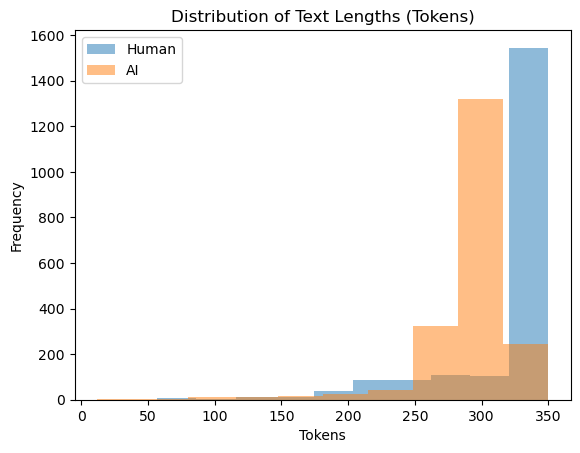

In [87]:

enc = tiktoken.get_encoding("cl100k_base")

# Count tokens instead of words
df['human_token_len'] = df['human_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

df['ai_token_len'] = df['ai_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

# Plot token distributions
plt.hist(df['human_token_len'].dropna(), alpha=0.5, label='Human')
plt.hist(df['ai_token_len'].dropna(), alpha=0.5, label='AI')
plt.legend()
plt.title("Distribution of Text Lengths (Tokens)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()


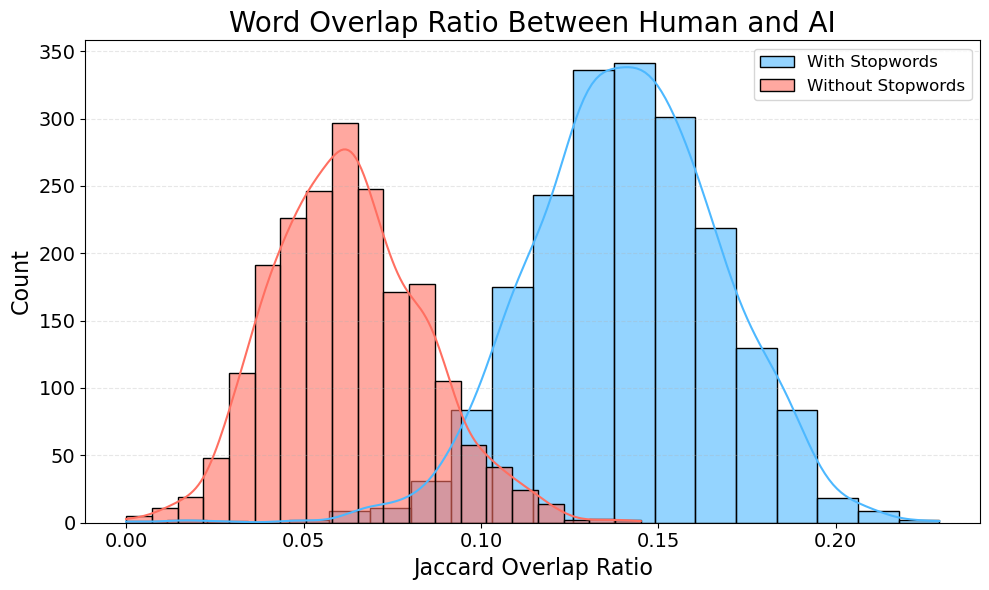

In [88]:
stop_words = set(stopwords.words("english"))

# פונקציה: overlap בלי stopwords
def word_overlap_no_stopwords(h, a):
    h_words = set(w for w in str(h).split() if w.lower() not in stop_words)
    a_words = set(w for w in str(a).split() if w.lower() not in stop_words)
    if not h_words or not a_words:
        return 0
    return len(h_words & a_words) / len(h_words | a_words)

# פונקציה: overlap כולל stopwords
def word_overlap(h, a):
    h_set = set(str(h).split())
    a_set = set(str(a).split())
    if not h_set or not a_set:
        return 0
    return len(h_set & a_set) / len(h_set | a_set)

# חישוב
overlap_with = df.apply(lambda row: word_overlap(row["human_text_350"], row["ai_text_350"]), axis=1)
overlap_no_stop = df.apply(lambda row: word_overlap_no_stopwords(row["human_text_350"], row["ai_text_350"]), axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.histplot(overlap_with, bins=20, kde=True, color="#4DB8FF", label="With Stopwords", alpha=0.6)
sns.histplot(overlap_no_stop, bins=20, kde=True, color="#FF6F61", label="Without Stopwords", alpha=0.6)

plt.title("Word Overlap Ratio Between Human and AI", fontsize=20)
plt.xlabel("Jaccard Overlap Ratio", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

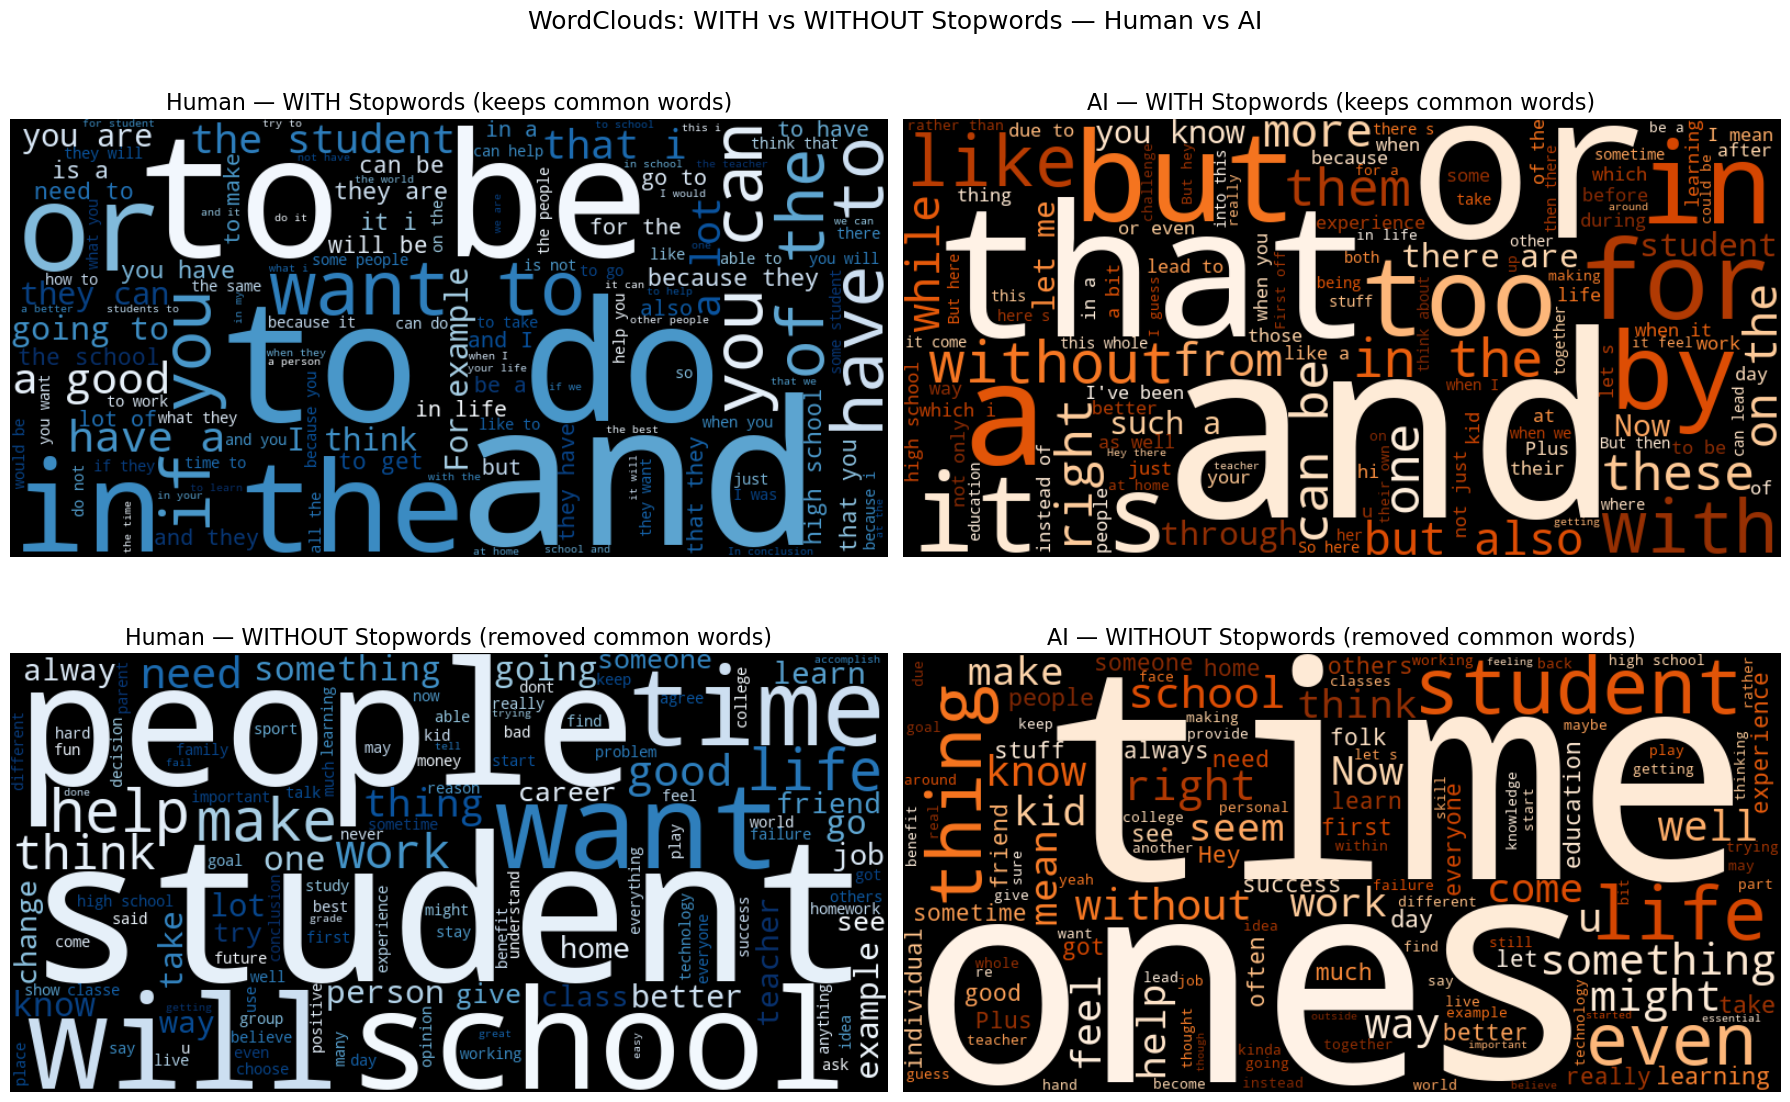

In [89]:

# --- Parameters you can change ---
# אם הטקסטים שלך בעברית, תחליף english_stopwords ברשימת stopwords בעברית
english_stopwords = set(STOPWORDS)   # standard english stopwords
use_collocations = True             # True = include bigrams; False = single-word only
random_state = 42
wc_width, wc_height = 800, 400
max_words = 120

# --- Prepare texts ---
human_text = " ".join(df['human_text_350'].dropna().astype(str))
ai_text    = " ".join(df['ai_text_350'].dropna().astype(str))

# --- Shared WordCloud params ---
base_params = dict(
    width=wc_width,
    height=wc_height,
    background_color="black",
    collocations=use_collocations,
    random_state=random_state,
    max_words=max_words
)

# --- Create 4 word clouds
# Note the naming: WITHOUT stopwords => we REMOVE stopwords => pass stopwords=english_stopwords
#           WITH stopwords    => we KEEP stopwords      => pass stopwords=set()
wc_human_withSW    = WordCloud(**base_params, colormap="Blues",   stopwords=set()).generate(human_text or " ")
wc_human_withoutSW = WordCloud(**base_params, colormap="Blues",   stopwords=english_stopwords).generate(human_text or " ")

wc_ai_withSW       = WordCloud(**base_params, colormap="Oranges", stopwords=set()).generate(ai_text or " ")
wc_ai_withoutSW    = WordCloud(**base_params, colormap="Oranges", stopwords=english_stopwords).generate(ai_text or " ")

# --- Plot 2x2 (top-left = WITH stopwords, bottom-left = WITHOUT stopwords) ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0,0].imshow(wc_human_withSW, interpolation="bilinear")
axes[0,0].set_title("Human — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,0].axis("off")

axes[1,0].imshow(wc_human_withoutSW, interpolation="bilinear")
axes[1,0].set_title("Human — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,0].axis("off")

axes[0,1].imshow(wc_ai_withSW, interpolation="bilinear")
axes[0,1].set_title("AI — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,1].axis("off")

axes[1,1].imshow(wc_ai_withoutSW, interpolation="bilinear")
axes[1,1].set_title("AI — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,1].axis("off")

plt.suptitle("WordClouds: WITH vs WITHOUT Stopwords — Human vs AI", fontsize=18)
plt.tight_layout()
plt.show()

C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_12728\3668757483.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


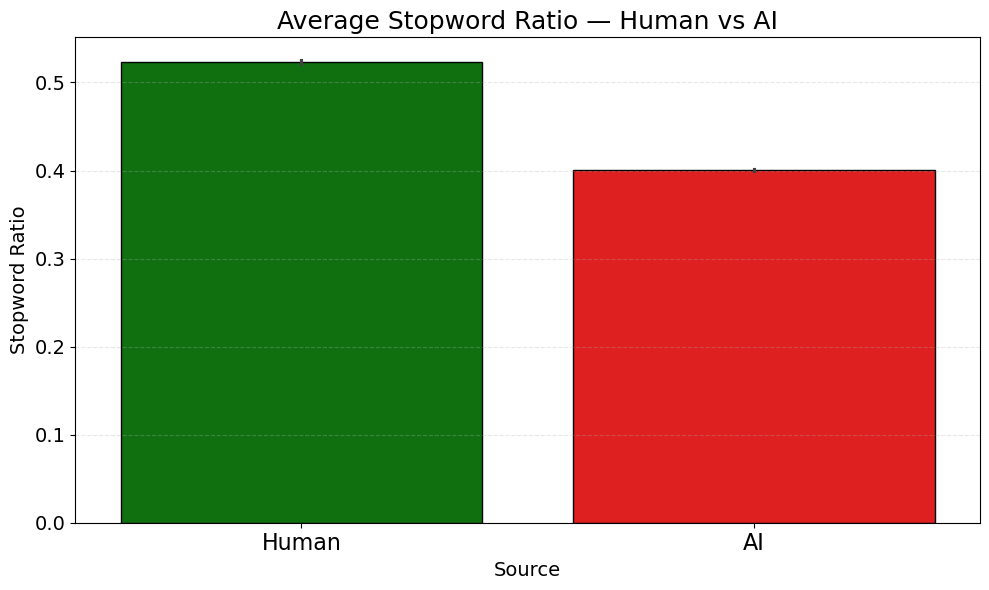

In [90]:
stop_words = set(stopwords.words("english"))

def stopword_ratio(text):
    words = text.split()
    if len(words)==0: return 0
    return sum(1 for w in words if w.lower() in stop_words)/len(words)

df_stop = pd.DataFrame({
    "Human": df["human_text_350"].fillna("").astype(str).map(stopword_ratio),
    "AI": df["ai_text_350"].fillna("").astype(str).map(stopword_ratio),
})

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_stop.melt(var_name="source", value_name="stopword_ratio"), 
    x="source", 
    y="stopword_ratio", 
    palette=["green","red"],  # ירוק ל-Human, אדום ל-AI
    edgecolor="black"
)
plt.title("Average Stopword Ratio — Human vs AI", fontsize=18)
plt.ylabel("Stopword Ratio", fontsize=14)
plt.xlabel("Source", fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

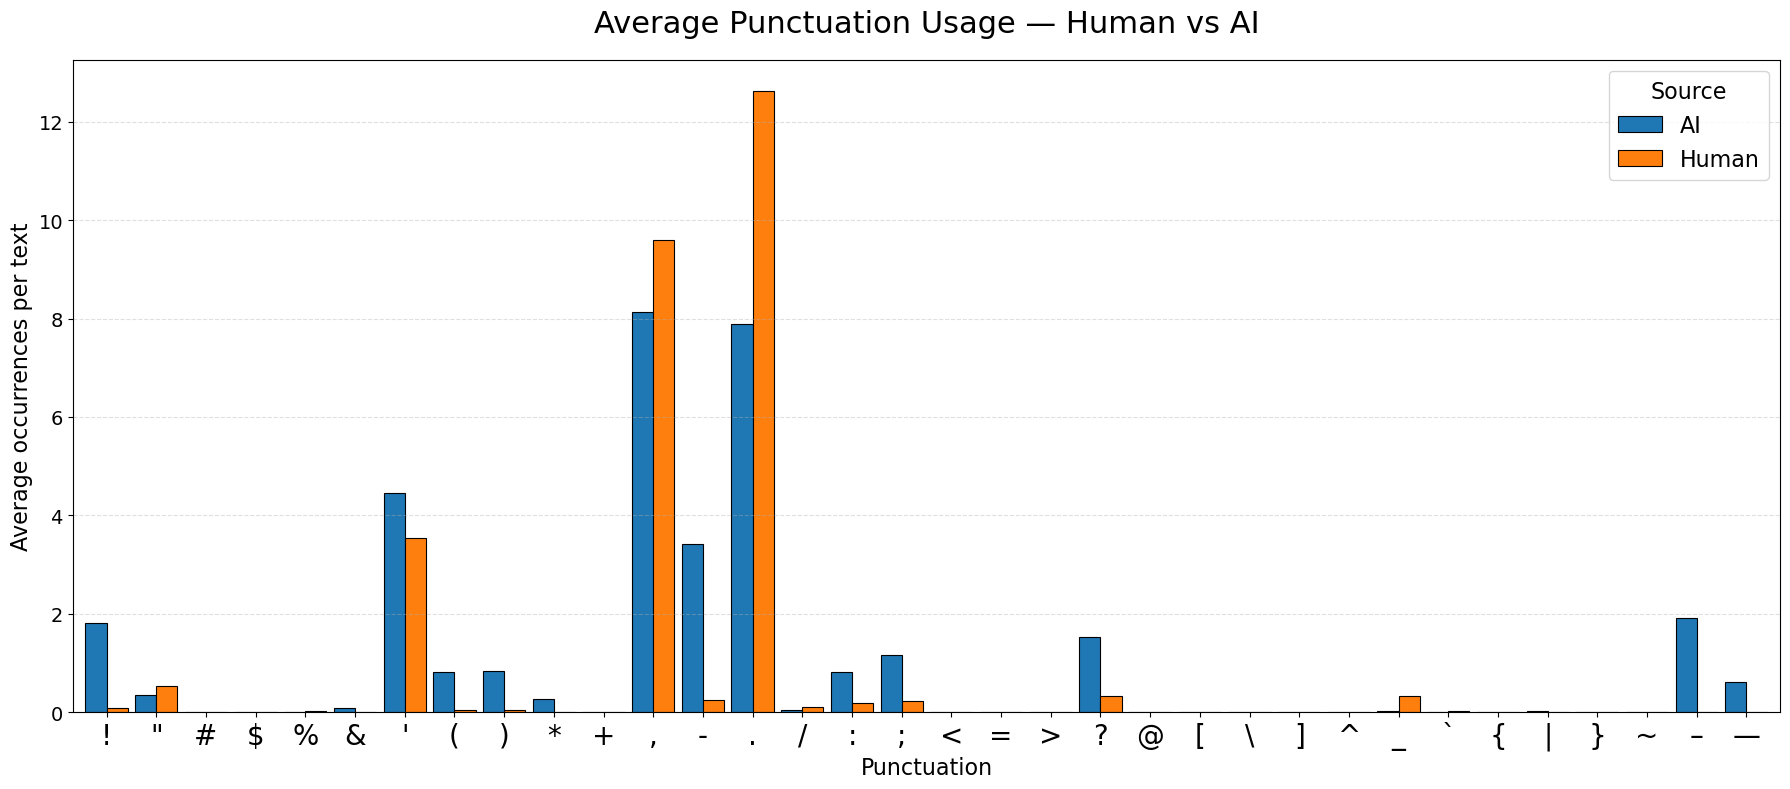

In [91]:

# -------------------------
# Normalize DF into "source" + "text" structure (Human & AI)
# -------------------------
df_punct = pd.DataFrame({
    "source": ["Human"] * len(df) + ["AI"] * len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
            + df["ai_text_350"].fillna("").astype(str).tolist()
})

# -------------------------
# Define punctuation char list (includes en dash & em dash)
# -------------------------
punctuations = string.punctuation + "–—"

# For plotting purposes, we capture readable names:
def safe_name(p):
    if p == "–": return "endash"
    if p == "—": return "emdash"
    return p

# -------------------------
# Count punctuation occurrences per text
# -------------------------
for p in punctuations:
    df_punct[f"count_{safe_name(p)}"] = df_punct["text"].str.count(re.escape(p))

# -------------------------
# Compute mean usage per punctuation per source
# -------------------------
punct_avg = (
    df_punct.groupby("source")[
        [col for col in df_punct.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)

# Replace safe names back to real characters
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
                   .str.replace("endash", "–", regex=False)
                   .str.replace("emdash", "—", regex=False)
)

# -------------------------
# Final high-quality plot
# -------------------------
plt.figure(figsize=(18, 8))
punct_avg.plot(
    kind="bar",
    figsize=(18, 8),
    width=0.85,
    edgecolor="black",
    linewidth=0.8
)

plt.title("Average Punctuation Usage — Human vs AI", fontsize=22, pad=20)
plt.ylabel("Average occurrences per text", fontsize=16)
plt.xlabel("Punctuation", fontsize=16)

plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.legend(fontsize=16, title="Source", title_fontsize=16)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [92]:

# נניח שיש לך df עם העמודות human_text ו-ai_response
# נמזג אותם ל-DF אחיד עם 'source' ו-'text'
df_ratio = pd.DataFrame({
    "source": ["Human"]*len(df) + ["AI"]*len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
             + df["ai_text_350"].fillna("").astype(str).tolist()
})

# פונקציה שמחשבת unique word ratio
def unique_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

df_ratio["unique_ratio"] = df_ratio["text"].apply(unique_ratio)

# ממוצע לכל source
avg_unique_ratio = df_ratio.groupby("source")["unique_ratio"].mean().reset_index()
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

print(avg_unique_ratio)

  source  avg_unique_ratio
0     AI          0.754232
1  Human          0.477273


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_12728\3754287975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


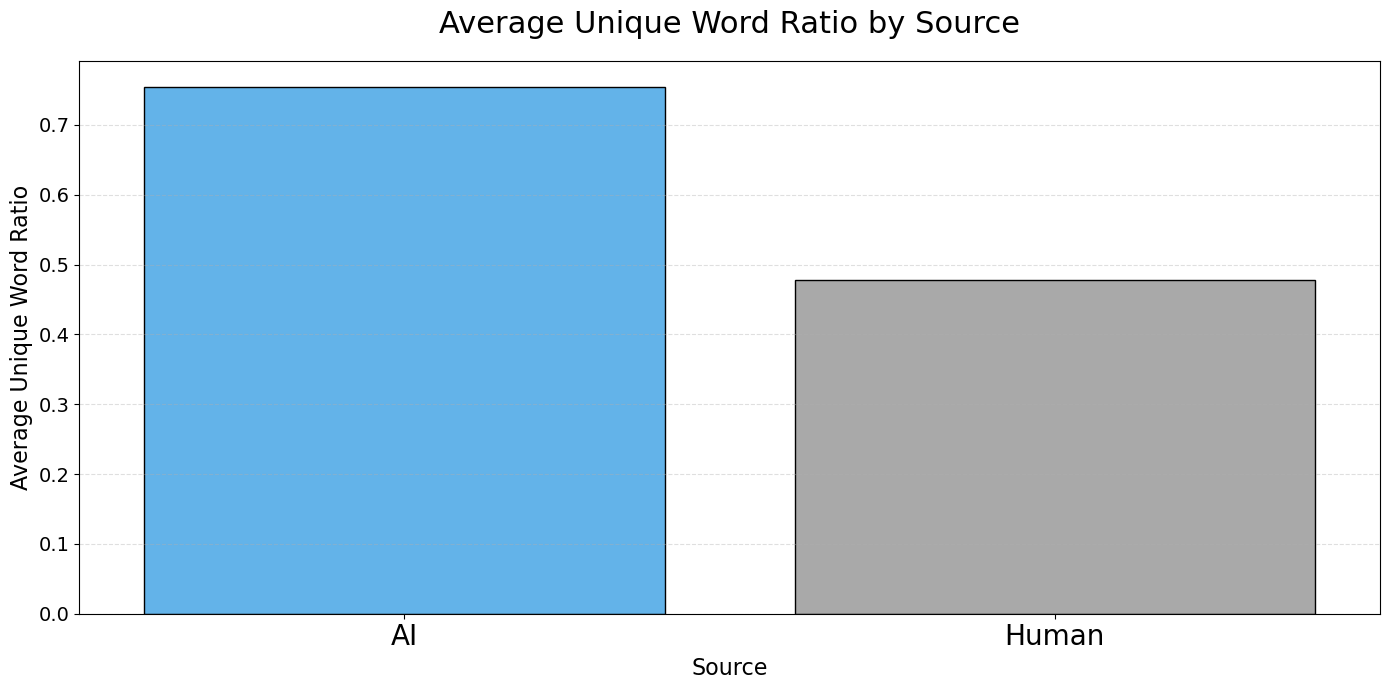

In [93]:
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_unique_ratio,
    x="source",
    y="avg_unique_ratio",
    palette=["#4DB8FF", "#A9A9A9"],  # תכלת ל-Human, אפור ל-AI
    edgecolor="black"
)

plt.title("Average Unique Word Ratio by Source", fontsize=22, pad=20)
plt.xlabel("Source", fontsize=16)
plt.ylabel("Average Unique Word Ratio", fontsize=16)
plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



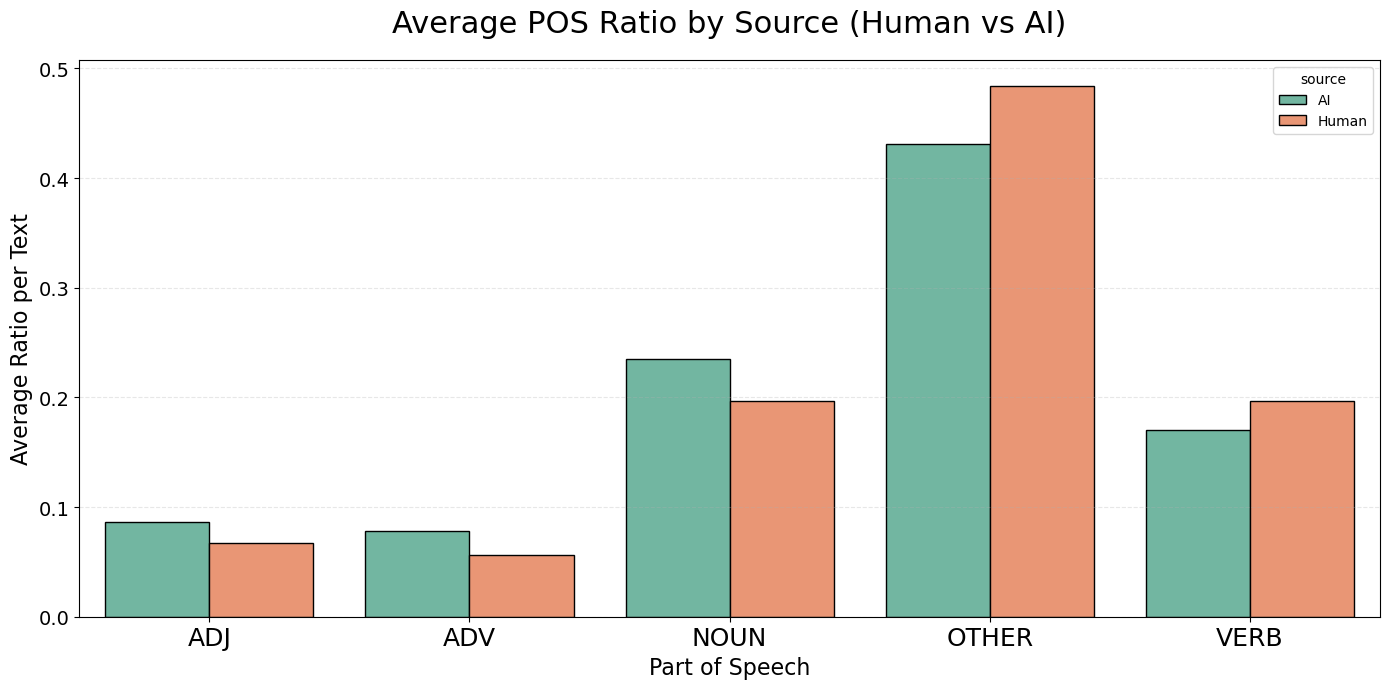

In [94]:

# --- POS Tagging Function ---
def get_pos_groups(text):
    """Return POS counts for a single text as a dict"""
    counts = {"NOUN":0, "VERB":0, "ADJ":0, "ADV":0, "OTHER":0}
    if not isinstance(text, str):
        return counts
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    for _, pos in tags:
        if pos.startswith("N"):
            counts["NOUN"] += 1
        elif pos.startswith("V"):
            counts["VERB"] += 1
        elif pos.startswith("J"):
            counts["ADJ"] += 1
        elif pos.startswith("R"):
            counts["ADV"] += 1
        else:
            counts["OTHER"] += 1
    return counts

# --- Prepare POS counts for Human and AI ---
records = []

for source_name, col in [("Human","human_text_350"), ("AI","ai_text_350")]:
    for t in df[col].dropna().astype(str):
        pos_counts = get_pos_groups(t)
        total_tokens = sum(pos_counts.values())
        # Compute ratio per POS
        for pos, count in pos_counts.items():
            ratio = count / total_tokens if total_tokens > 0 else 0
            records.append({"source": source_name, "pos": pos, "ratio": ratio})

pos_ratio_df = pd.DataFrame(records)

# --- Compute average ratio per POS per source ---
avg_pos_ratio = pos_ratio_df.groupby(["source","pos"])["ratio"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_pos_ratio,
    x="pos",
    y="ratio",
    hue="source",
    palette="Set2",
    edgecolor="black"
)

plt.title("Average POS Ratio by Source (Human vs AI)", fontsize=22, pad=20)
plt.xlabel("Part of Speech", fontsize=16)
plt.ylabel("Average Ratio per Text", fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Embeddings

In [19]:
# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)


In [20]:
data

,text,instructions,label
0,You can also shop online without having to lea...,Task: Analyze the positive impacts of technolo...,0
1,so just know that your thankful for people wan...,Task: Task:\n\n1. Ask two or more people for a...,0
2,Pursuit of success i hope so the maen idea is ...,Task: Write an essay that examines the idea th...,0
3,So then people end up living check by check an...,Task: Research the benefits of having partners...,0
4,Imitating someone else that has had such a gre...,Task: Task:\n1. Research ways in which people ...,0
...,...,...,...
13995,"Outdoor adventures are a breath of fresh air, ...",Task: Write an essay on the importance of outd...,1
13996,I've been curious about what draws folks from ...,"Task: Research why people love to visit Korea,...",1
13997,"Hey there, I've gotta say that teaming up with...",Task: Task:\nExplore the benefits of working i...,1
13998,Hey everyone! I've been thinking a lot about t...,Task: Examine the benefits of having an age mi...,1


In [21]:
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_tfidf_word = tfidf_word.fit_transform(texts)

df_tfidf_word = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf_word,
    columns=tfidf_word.get_feature_names_out()
)

df_tfidf_word["label"] = y.values

In [22]:
X_tfidf_word

<14000x61786 sparse matrix of type '<class 'numpy.float64'>'
	with 1909578 stored elements in Compressed Sparse Row format>

In [23]:
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5
)

X_tfidf_char = tfidf_char.fit_transform(texts)
y = y.values


In [24]:
X_tfidf_char

<14000x168392 sparse matrix of type '<class 'numpy.float64'>'
	with 38984868 stored elements in Compressed Sparse Row format>

In [25]:
bow = CountVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_bow = bow.fit_transform(texts)


In [26]:
X_bow

<14000x61786 sparse matrix of type '<class 'numpy.int64'>'
	with 1909578 stored elements in Compressed Sparse Row format>

In [27]:
# Tokenize texts
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # skip-gram
)

# Function to average word vectors
def document_vector(doc):
    vectors = [
        w2v_model.wv[word]
        for word in doc
        if word in w2v_model.wv
    ]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack([document_vector(doc) for doc in tokenized_texts])

# Convert to DataFrame
df_w2v = pd.DataFrame(
    X_w2v,
    columns=[f"w2v_{i}" for i in range(X_w2v.shape[1])]
)
scaler = StandardScaler()

X_w2v_scaled = scaler.fit_transform(df_w2v)

df_w2v_scaled = pd.DataFrame(
    X_w2v_scaled,
    columns=df_w2v.columns
)

df_w2v_scaled["label"] = y

df_w2v_scaled

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,label
0,-0.302321,1.832870,-0.385189,0.247313,0.844371,1.034225,0.240109,-2.091041,-0.454311,1.216438,...,-0.448081,-0.688578,-0.157137,-1.781495,-0.571533,-0.570585,1.268969,1.716108,-0.790826,0
1,1.705263,-0.024330,-0.736844,-0.873880,1.113027,-1.670870,0.077495,-1.713123,0.392858,-0.510797,...,2.877982,1.527345,1.279606,-0.608717,-0.816841,-1.148827,-1.332549,0.156407,0.403818,0
2,-0.714186,2.016294,1.096910,1.794693,0.655696,1.428650,-1.185773,2.310780,2.347202,-3.736587,...,-0.235803,-0.725084,-2.198869,-2.232960,-0.669611,-1.103077,-1.617734,1.360458,4.142274,0
3,0.639336,1.319545,-0.130434,-0.891153,1.017116,0.476204,-0.528485,-0.118104,0.249856,-0.316254,...,-0.042477,1.697011,0.222013,-0.564881,0.795256,-0.401900,-0.104542,-1.231815,-0.133830,0
4,0.967842,0.078263,-1.116797,-0.129447,-0.021345,0.262704,-1.337676,0.482840,0.465839,0.018778,...,-0.284706,-0.741049,-0.739626,-0.620291,-0.817926,-0.671405,-0.825384,-0.842172,1.094551,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.055043,0.468320,0.692711,0.630233,-0.814465,0.154280,-0.750103,0.957472,-0.528633,-0.051949,...,-0.991518,-1.149001,-0.562171,1.393593,-0.522890,0.471343,1.062763,0.916139,-1.005358,1
13996,0.180564,1.060961,0.997830,-0.383469,-0.430171,-0.032351,-1.185842,0.013392,-0.923888,0.654659,...,-0.726018,-0.913961,0.704358,1.073507,-0.904721,0.351541,-0.848148,0.410699,-0.222981,1
13997,-0.049376,-0.797789,0.264957,0.005610,-0.790792,-1.020226,-0.578350,0.048987,-1.196138,-0.260263,...,-0.516956,-0.204533,1.121656,1.081543,0.230640,2.074857,-0.298629,0.413970,0.492868,1
13998,-0.098682,-0.887853,0.891761,0.158110,-1.184074,-0.198085,0.940749,-0.913973,-0.541019,0.274408,...,0.483647,-0.142460,0.773090,0.608148,0.840806,0.618285,-0.220498,-0.659464,0.211632,1


In [28]:
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=gkf.split(X_tfidf_char, y, groups),
    scoring="accuracy"
)

print("Grouped CV accuracy:", scores.mean())


Grouped CV accuracy: 0.9991427549562161


In [29]:
scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=5,
    scoring="accuracy"
)

print("TF-IDF char accuracy:", scores.mean())

TF-IDF char accuracy: 0.9982857142857142


# Vectors

In [32]:
def get_top_words_combined(df, stopwords, top_k=20):
    words = []
    for text in df['text']:
        if pd.isna(text):
            continue
        text = str(text)
        # מילים באורך ≥2
        tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        tokens = [w for w in tokens if w not in stopwords]
        words.extend(tokens)
    # 10 המילים הכי נפוצות
    top_words = [w for w, _ in Counter(words).most_common(top_k)]
    return top_words

# הפעלה על כל הדאטה (HUMAN + AI יחד)
top_20_words = get_top_words_combined(data, STOPWORDS, top_k=20)
print("Top 10 most frequent words:", top_20_words)

Top 10 most frequent words: ['people', 'school', 'students', 'time', 'life', 'will', 'work', 'good', 'one', 'make', 'think', 'help', 'something', 'want', 'know', 'things', 'better', 'don', 'need', 'us']


In [33]:
def extract_all_features(text, top_words):
    if pd.isna(text):
        text = ""
    text = str(text)
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    counts = Counter(words)
    total_words = len(words)
    unique_words = len(counts)
    probs = np.array(list(counts.values())) / total_words if total_words > 0 else np.array([1])

    # משפטים
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(s.split()) for s in sentences if s.strip()]

    features = {}

    # -------------------------
    # סטטיסטיים / טקסטואליים
    # -------------------------
    features["unique_word_ratio"] = unique_words / total_words if total_words > 0 else 0
    features["punctuation_ratio"] = sum(text.count(p) for p in punctuations) / max(1, len(text))
    features["capitalized_word_ratio"] = sum(w[0].isupper() for w in text.split() if w) / max(1, len(text.split()))
    features["digit_ratio"] = sum(c.isdigit() for c in text) / max(1, len(text))
    features["most_common_word_ratio"] = counts.most_common(1)[0][1] / total_words if total_words > 0 else 0
    features["entropy_words"] = entropy(probs)

    # -------------------------
    # One-Hot על המילים הנבחרות
    # -------------------------
    word_set = set(words)
    for w in top_words:
        features[f'has_{w}'] = int(w in word_set)

    return features

In [34]:
punctuations = string.punctuation
custom_vector_df = data['text'].apply(
    lambda x: extract_all_features(x, top_20_words)
).apply(pd.Series)

custom_vector_df['label'] = data['label'].values
custom_vector_df

,unique_word_ratio,punctuation_ratio,capitalized_word_ratio,digit_ratio,most_common_word_ratio,entropy_words,has_people,has_school,has_students,has_time,...,has_help,has_something,has_want,has_know,has_things,has_better,has_don,has_need,has_us,label
0,0.338658,0.012746,0.055901,0.00000,0.070288,4.186556,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.467742,0.016512,0.037234,0.00000,0.102151,4.132564,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,0.351064,0.018001,0.090909,0.00000,0.067376,4.179954,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
3,0.457680,0.014159,0.024390,0.00354,0.050157,4.643043,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4,0.477987,0.012783,0.027692,0.00000,0.034591,4.699959,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.717054,0.020434,0.052434,0.00000,0.023256,5.053819,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
13996,0.851351,0.018605,0.118421,0.00000,0.033784,4.760094,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
13997,0.717472,0.019888,0.060932,0.00000,0.022305,5.117927,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
13998,0.727273,0.023291,0.075221,0.00000,0.022727,4.951658,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1


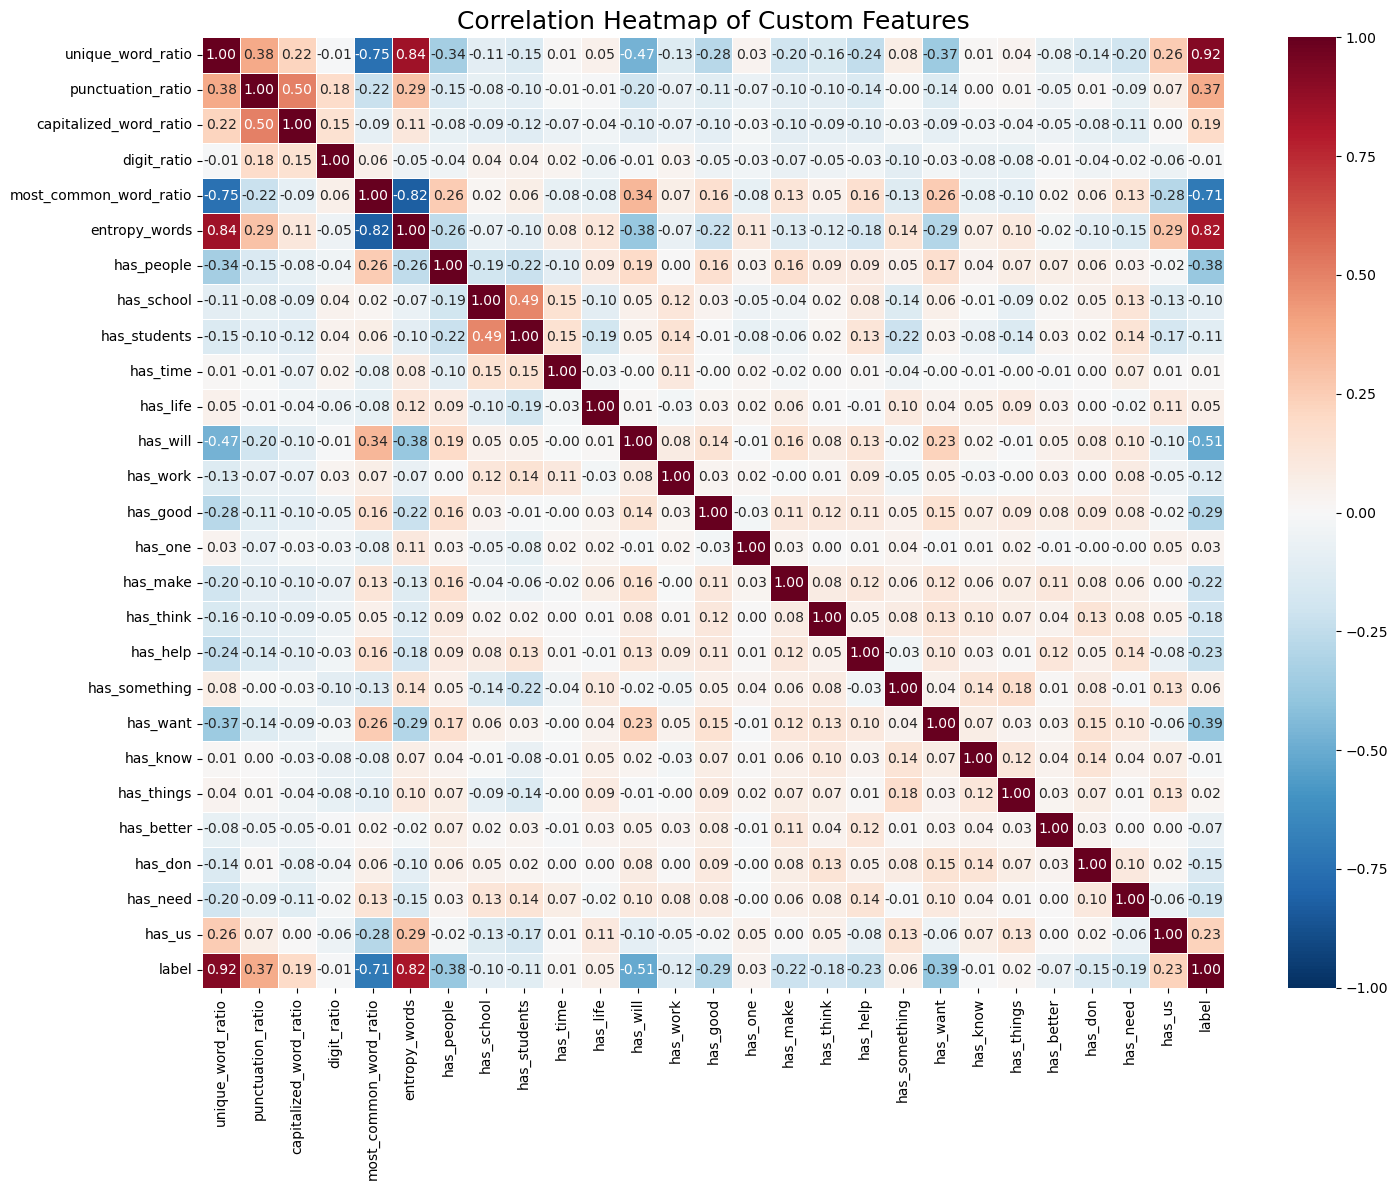

In [35]:
corr_matrix = custom_vector_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(
    corr_matrix,
    annot=True,            # להוסיף את ערכי הקורלציה בתאים
    fmt=".2f",             # פורמט עם 2 ספרות אחרי הנקודה
    cmap="RdBu_r",          # אדום–כחול הפוך: כחול=שלילי, אדום=חיובי
    vmin=-1, vmax=1,       # תחום הקורלציה
    center=0,              # מרכז הצבע = 0
    linewidths=0.5         # קווים בין התאים
)
plt.title("Correlation Heatmap of Custom Features", fontsize=18)
plt.tight_layout()
plt.show()

# LogisticRegression

In [36]:
# --- Custom Features ---
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

scores_custom = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_custom,
    y_custom,
    cv=5,
    scoring="accuracy"
)
print("Custom Features CV accuracy:", scores_custom.mean())

# --- Word2Vec ---
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

scores_w2v = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_w2v,
    y_w2v,
    cv=5,
    scoring="accuracy"
)
print("Word2Vec CV accuracy:", scores_w2v.mean())

# --- Bag of Words ---
scores_bow = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_bow,
    y,
    cv=5,
    scoring="accuracy"
)
print("Bag of Words CV accuracy:", scores_bow.mean())

# --- TF-IDF Word ---
scores_tfidf_word = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_word,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_word = scores_tfidf_word.mean()
print("TF-IDF Word CV accuracy:", acc_tfidf_word)

# --- TF-IDF Char ---
scores_tfidf_char = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_char = scores_tfidf_char.mean()
print("TF-IDF Char CV accuracy:", acc_tfidf_char)

Custom Features CV accuracy: 0.9811428571428571
Word2Vec CV accuracy: 0.999
Bag of Words CV accuracy: 0.998
TF-IDF Word CV accuracy: 0.9949285714285715
TF-IDF Char CV accuracy: 0.9982857142857142


In [37]:
# יצירת טבלת LR עם עמודת Model
results = pd.DataFrame({
    "Representation": ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"],
    "Accuracy": [
        scores_custom.mean(),
        scores_w2v.mean(),
        scores_bow.mean(),
        acc_tfidf_word,
        acc_tfidf_char
    ],
    "Model": ["Logistic Regression"] * 5  # מוסיפים עמודת Model
})

# מיון לפי Accuracy
results = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

results

,Representation,Accuracy,Model
0,Word2Vec,0.999000,Logistic Regression
1,TF-IDF Char,0.998286,Logistic Regression
2,Bag of Words,0.998000,Logistic Regression
3,TF-IDF Word,0.994929,Logistic Regression
4,Custom Features,0.981143,Logistic Regression


In [38]:
def evaluate_model(X, y, title):
    model = LogisticRegression(max_iter=1000)

    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{title} CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=5)

    cm = confusion_matrix(y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

Custom Features CV accuracy: 0.9811428571428571


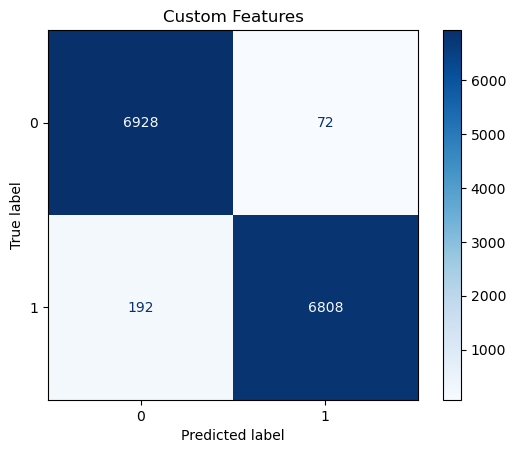

In [39]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_model(X_custom, y_custom, "Custom Features")


Word2Vec CV accuracy: 0.999


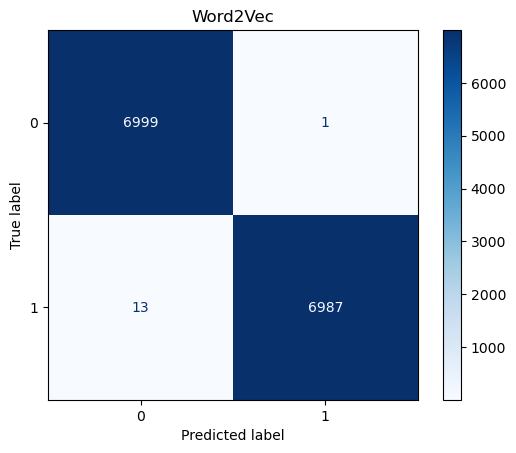

In [40]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_model(X_w2v, y_w2v, "Word2Vec")


Bag of Words CV accuracy: 0.998


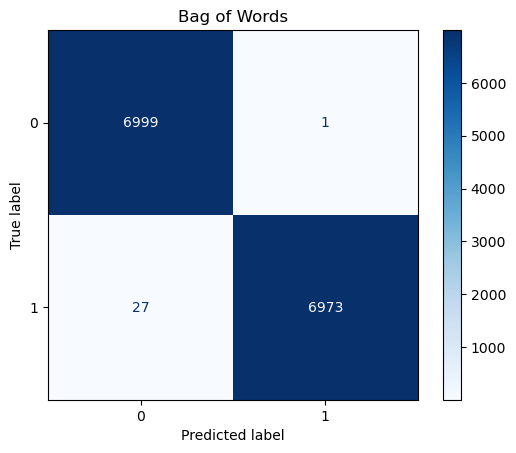

In [41]:
evaluate_model(X_bow, y, "Bag of Words")


TF-IDF Word CV accuracy: 0.9949285714285715


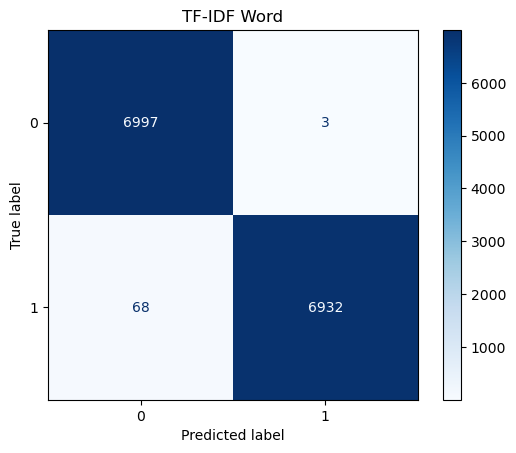

In [42]:
evaluate_model(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char CV accuracy: 0.9982857142857142


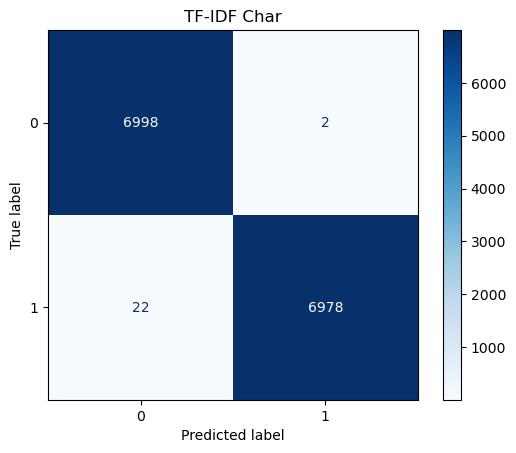

In [43]:
evaluate_model(X_tfidf_char, y, "TF-IDF Char")


# XGboost

In [32]:
def evaluate_xgboost(X, y, title):
    model = XGBClassifier(
        n_estimators=50,       
        max_depth=3,           
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1              
    )


    scores = cross_val_score(model, X, y, cv=3, scoring="accuracy")
    print(f"{title} (XGBoost FAST) CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=3)

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{title} - XGBoost FAST")
    plt.show()

Custom Features (XGBoost FAST) CV accuracy: 0.951931943627932


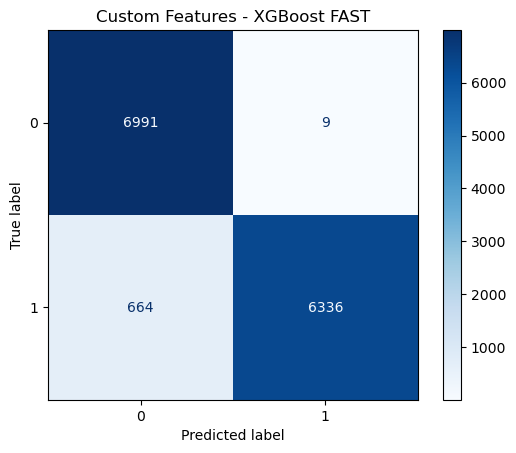

In [33]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_xgboost(X_custom, y_custom, "Custom Features")


Word2Vec (XGBoost FAST) CV accuracy: 0.9925718673024795


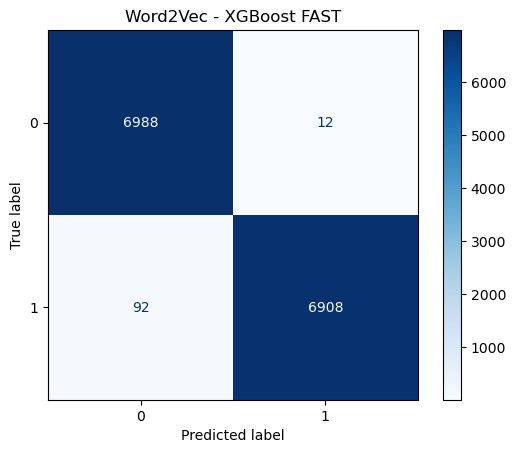

In [34]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_xgboost(X_w2v, y_w2v, "Word2Vec")


Bag of Words (XGBoost FAST) CV accuracy: 0.9043633923276498


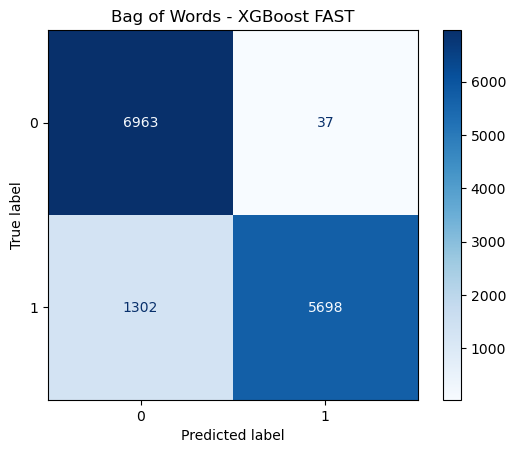

In [35]:
evaluate_xgboost(X_bow, y, "Bag of Words")


TF-IDF Word (XGBoost FAST) CV accuracy: 0.8979354025076832


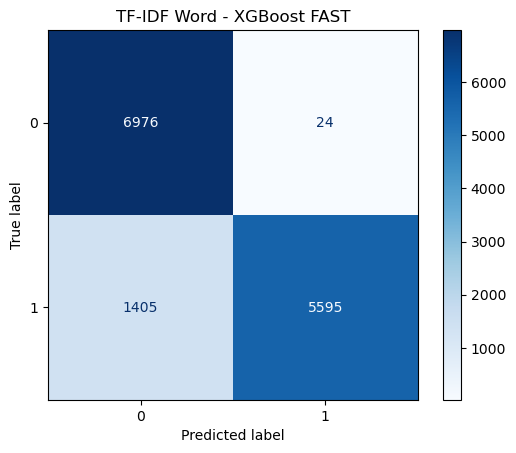

In [36]:
evaluate_xgboost(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char (XGBoost FAST) CV accuracy: 0.9529319181261102


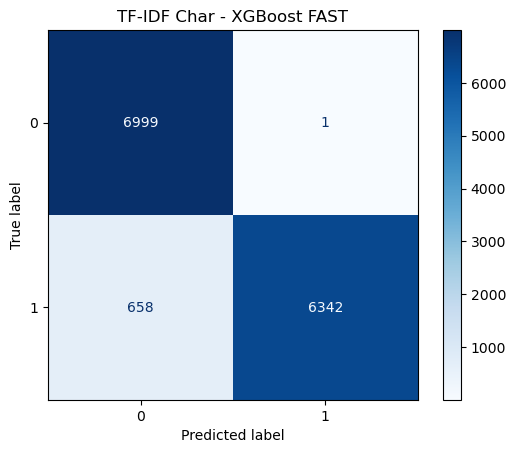

In [37]:
evaluate_xgboost(X_tfidf_char, y, "TF-IDF Char")


In [38]:
# ==========================
# XGBoost
# ==========================

# --- Custom Features ---
scores_xgb = {}
scores_xgb["Custom Features"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_custom, y_custom, cv=3, scoring="accuracy"
).mean()

# --- Word2Vec ---
scores_xgb["Word2Vec"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_w2v, y_w2v, cv=3, scoring="accuracy"
).mean()

# --- Bag of Words ---
scores_xgb["Bag of Words"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_bow, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Word ---
scores_xgb["TF-IDF Word"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_word, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Char ---
scores_xgb["TF-IDF Char"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_char, y, cv=3, scoring="accuracy"
).mean()

In [39]:
# ==========================
# יצירת טבלת תוצאות מסודרת
# ==========================

xgb_df = pd.DataFrame([
    {"Model": "XGBoost", "Features": k, "Accuracy": v}
    for k, v in scores_xgb.items()
]).sort_values(
    by="Accuracy", ascending=False
).reset_index(drop=True)

# הצגת הטבלה
print("XGBoost – Cross Validation Accuracy Results")
xgb_df

XGBoost – Cross Validation Accuracy Results


,Model,Features,Accuracy
0,XGBoost,Word2Vec,0.992572
1,XGBoost,TF-IDF Char,0.952932
2,XGBoost,Custom Features,0.951932
3,XGBoost,Bag of Words,0.904363
4,XGBoost,TF-IDF Word,0.897935


In [40]:
features = ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"]

# רשימת Accuracy של LR
lr_acc = [
    scores_custom.mean(),
    scores_w2v.mean(),
    scores_bow.mean(),
    acc_tfidf_word,
    acc_tfidf_char
]

# רשימת Accuracy של XGBoost (מהטבלה xgb_df)
xgb_acc = [xgb_df.loc[xgb_df["Features"] == f, "Accuracy"].values[0] for f in features]

# בנייה של טבלת long format
combined_long = pd.DataFrame({
    "Representation": features * 2,           # כל פיצ'ר מופיע פעמיים
    "Model": ["Logistic Regression"] * 5 + ["XGBoost"] * 5,
    "Accuracy": lr_acc + xgb_acc
})


combined_long = combined_long.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

combined_long

,Representation,Model,Accuracy
0,Word2Vec,Logistic Regression,0.999071
1,TF-IDF Char,Logistic Regression,0.998286
2,Bag of Words,Logistic Regression,0.998000
3,TF-IDF Word,Logistic Regression,0.994929
4,Word2Vec,XGBoost,0.992572
5,Custom Features,Logistic Regression,0.981143
6,TF-IDF Char,XGBoost,0.952932
7,Custom Features,XGBoost,0.951932
8,Bag of Words,XGBoost,0.904363
9,TF-IDF Word,XGBoost,0.897935


In [41]:
model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.2,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

model.fit(X_tfidf_char, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, ...)

In [42]:
def get_feature_importance_xgb(model, importance_type="gain"):
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type=importance_type)
    
    importance_df = pd.DataFrame({
        "feature": importance_dict.keys(),
        "importance": importance_dict.values()
    }).sort_values(by="importance", ascending=False)
    
    return importance_df

In [43]:
fi_gain = get_feature_importance_xgb(model, importance_type="gain")
fi_weight = get_feature_importance_xgb(model, importance_type="weight")
fi_cover = get_feature_importance_xgb(model, importance_type="cover")


In [44]:
fi_gain

,feature,importance
122,f167972,1178.891846
67,f75631,1050.953003
112,f148077,1011.247559
37,f26960,856.041321
74,f80552,816.729309
...,...,...
66,f72482,0.633656
80,f91617,0.620780
77,f89264,0.496655
54,f51371,0.201484


In [45]:
fi_weight

,feature,importance
32,f11420,21.0
122,f167972,19.0
29,f10143,15.0
1,f1356,13.0
0,f1171,12.0
...,...,...
13,f6227,1.0
14,f6321,1.0
58,f56318,1.0
57,f56313,1.0


In [46]:
fi_cover

,feature,importance
112,f148077,1940.238159
67,f75631,1875.878296
74,f80552,1591.626465
37,f26960,1275.592651
122,f167972,1078.846436
...,...,...
84,f97583,4.373536
19,f8622,3.882120
66,f72482,3.532356
106,f144413,2.901820


In [47]:
tfidf_char.get_feature_names_out()
feature_names = tfidf_char.get_feature_names_out()

def map_xgb_feature(f):
    return feature_names[int(f[1:])]
fi_gain["ngram"] = fi_gain["feature"].apply(map_xgb_feature)
fi_weight["ngram"] = fi_weight["feature"].apply(map_xgb_feature)

In [48]:
fi_gain.head(20)

,feature,importance,ngram
122,f167972,1178.891846,’s
67,f75631,1050.953003,ial
112,f148077,1011.247559,tial
37,f26960,856.041321,al
74,f80552,816.729309,int
29,f10143,349.743195,to
0,f1171,262.707672,-
64,f71723,234.685318,have
28,f10044,224.175140,the
12,f5739,212.258926,have


In [49]:
fi_weight

,feature,importance,ngram
32,f11420,21.0,–
122,f167972,19.0,’s
29,f10143,15.0,to
1,f1356,13.0,.
0,f1171,12.0,-
...,...,...,...
13,f6227,1.0,if
14,f6321,1.0,in
58,f56318,1.0,eopl
57,f56313,1.0,eop


# Evaluation

In [44]:
# Train final classifier on ALL data
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_w2v_scaled, y_w2v)


LogisticRegression(max_iter=1000)

In [45]:
# Map numeric labels to your new names
label_names = {
    0: "Human",
    1: "AI"
}

def predict_text_w2v(text):
    tokens = word_tokenize(text.lower())

    vectors = [
        w2v_model.wv[word]
        for word in tokens
        if word in w2v_model.wv
    ]

    doc_vec = (
        np.mean(vectors, axis=0)
        if vectors else
        np.zeros(w2v_model.vector_size)
    )

    doc_vec = doc_vec.reshape(1, -1)

    # Keep feature names to avoid warning
    doc_vec_df = pd.DataFrame(doc_vec, columns=df_w2v.columns)
    doc_vec_scaled = scaler.transform(doc_vec_df)

    # Predict
    pred_numeric = clf_w2v.predict(doc_vec_scaled)[0]
    probs = clf_w2v.predict_proba(doc_vec_scaled)[0]

    # Human-readable prediction
    pred_label = label_names[pred_numeric]

    print("\nClass probabilities:")
    for num_label, prob in zip(clf_w2v.classes_, probs):
        print(f"{label_names[num_label]}: {prob*100:.2f}%")

    confidence = probs.max() * 100
    print(f"\nFinal prediction: {pred_label} ({confidence:.2f}% confidence)")

    return pred_label, probs


In [46]:
user_text = input("Enter text: ")

label, probs = predict_text_w2v(user_text)

print("Class probabilities:", probs)



Class probabilities:
Human: 0.06%
AI: 99.94%

Final prediction: AI (99.94% confidence)
Class probabilities: [5.80433771e-04 9.99419566e-01]


In [47]:


# TF-IDF character n-grams
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5
)

X_tfidf_char = tfidf_char.fit_transform(texts)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tfidf_char, y)

label_names = {
    0: "Human",
    1: "AI"
}


In [48]:
label_names = {
    0: "Human",
    1: "AI"
}
def predict_text(text):
    # Vectorize input text
    X_input = tfidf_char.transform([text])

    # Predict
    pred_numeric = clf.predict(X_input)[0]
    probs = clf.predict_proba(X_input)[0]

    pred_label = label_names[pred_numeric]

    print("\nClass probabilities:")
    for num_label, prob in zip(clf.classes_, probs):
        print(f"{label_names[num_label]}: {prob * 100:.2f}%")

    confidence = probs.max() * 100
    print(f"\nFinal prediction: {pred_label} ({confidence:.2f}% confidence)")

    return pred_label, probs


In [49]:
user_text = input("Enter text: ")
label, probs = predict_text(user_text)
print("Class probabilities:", probs)



Class probabilities:
Human: 17.99%
AI: 82.01%

Final prediction: AI (82.01% confidence)
Class probabilities: [0.17985726 0.82014274]


In [24]:
ESSAY_TOPICS = [
    "A moment that completely changed how you see the world",
    "Why boredom is actually important",
    "Something people pretend to understand but usually don't",
    "A small decision that had big consequences",
    "Why modern life feels overwhelming",
    "An opinion you changed your mind about",
    "The problem with being productive all the time",
    "Why nostalgia is dangerous",
    "What social media does to friendships",
    "Why people romanticize the past",

    "A time you were confidently wrong",
    "What nobody tells you about growing up",
    "Why silence makes people uncomfortable",
    "How routines quietly shape who we are",
    "Why people are afraid of being average",
    "The pressure to always have an opinion",
    "Why convenience is making life worse",
    "What failure actually teaches",
    "Why people miss things they never had",
    "How expectations ruin experiences",

    "Why being busy feels safer than being honest",
    "The difference between being alone and being lonely",
    "Why people avoid difficult conversations",
    "How habits slowly become identity",
    "Why first impressions matter too much",
    "What it means to feel behind in life",
    "Why people chase motivation instead of discipline",
    "The emotional cost of constant comparison",
    "Why people confuse confidence with certainty",
    "How comfort zones quietly shrink",

    "Why apologies are harder than they seem",
    "What people misunderstand about happiness",
    "Why choice can be exhausting",
    "How technology changes attention",
    "Why people fear being forgotten",
    "The quiet pressure to be successful",
    "Why people resist changing their minds",
    "How small habits reveal big values",
    "Why people avoid silence",
    "What disappointment teaches about expectations",

    "Why people overestimate their self-awareness",
    "How memory reshapes the past",
    "Why people struggle to rest without guilt",
    "The illusion of being productive",
    "Why people miss closure",
    "How identity shifts over time",
    "Why people romanticize struggle",
    "What it means to outgrow something",
    "Why people fear slowing down",
    "The problem with chasing potential",

    "Why people mistake busyness for purpose",
    "How fear disguises itself as logic",
    "Why people hold onto outdated beliefs",
    "The emotional weight of unfinished things",
    "Why people resist boredom",
    "How expectations shape disappointment",
    "Why people confuse comfort with happiness",
    "The subtle cost of convenience",
    "Why people fear being misunderstood",
    "How routine dulls awareness",

    "Why people avoid uncertainty",
    "What people get wrong about confidence",
    "Why people cling to familiarity",
    "The hidden impact of small choices",
    "Why people struggle with patience",
    "How social norms shape behavior",
    "Why people fear change even when unhappy",
    "The difference between growth and pressure",
    "Why people avoid introspection",
    "How modern life fragments attention",
    "Why people confuse movement with progress",
    "How comfort can quietly limit growth",
    "Why people avoid saying what they really mean",
    "The emotional impact of always being reachable",
    "Why people fear wasting time more than wasting energy",
    "How small disappointments accumulate over time",
    "Why people struggle to sit with uncertainty",
    "The difference between distraction and rest",
    "Why people resist changing routines that no longer help",
    "How expectations shape self-worth",

    "Why people mistake intensity for importance",
    "The quiet influence of social approval",
    "Why people delay decisions they already made emotionally",
    "How familiarity creates blind spots",
    "Why people avoid admitting they were wrong",
    "The cost of constantly optimizing life",
    "Why people fear missing out more than missing meaning",
    "How comparison subtly distorts self-image",
    "Why people feel guilty for slowing down",
    "The emotional weight of unfinished conversations",

    "Why people confuse being needed with being valued",
    "How modern life discourages patience",
    "Why people avoid confronting their own patterns",
    "The hidden pressure to appear confident",
    "Why people struggle to define success for themselves",
    "How silence exposes uncomfortable thoughts",
    "Why people cling to certainty in uncertain situations",
    "The difference between coping and healing",
    "Why people resist letting go of familiar discomfort",
    "How constant stimulation weakens attention"
]

In [ ]:
import pandas as pd
from openai import OpenAI

client = OpenAI(api_key="API_KEY_HERE")


df_test = pd.DataFrame({
    "instruction": [f"Write a reflective essay about: {t}" for t in ESSAY_TOPICS],
    "ai_response": [None] * len(ESSAY_TOPICS)
})

for i, prompt in enumerate(df_test["instruction"]):
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "Write like a human, no markdown or lists, natural tone."},
                {"role": "user", "content": prompt}
            ],
            max_completion_tokens=350
        )
        df_test.at[i, "ai_response"] = response.choices[0].message.content.strip()
        print(f"Generated essay {i+1}/{len(df_test)}")
    except Exception as e:
        print(f"Failed to generate essay {i}: {e}")
        df_test.at[i, "ai_response"] = "[FAILED]"

df_test.to_csv("ai_test.csv", index=False)


Generated essay 1/100
Generated essay 2/100
Generated essay 3/100
Generated essay 4/100
Generated essay 5/100
Generated essay 6/100
Generated essay 7/100
Generated essay 8/100
Generated essay 9/100
Generated essay 10/100
Generated essay 11/100
Generated essay 12/100
Generated essay 13/100
Generated essay 14/100
Generated essay 15/100
Generated essay 16/100
Generated essay 17/100
Generated essay 18/100
Generated essay 19/100
Generated essay 20/100
Generated essay 21/100
Generated essay 22/100
Generated essay 23/100
Generated essay 24/100
Generated essay 25/100
Generated essay 26/100
Generated essay 27/100
Generated essay 28/100
Generated essay 29/100
Generated essay 30/100
Generated essay 31/100
Generated essay 32/100
Generated essay 33/100
Generated essay 34/100
Generated essay 35/100
Generated essay 36/100
Generated essay 37/100
Generated essay 38/100
Generated essay 39/100
Generated essay 40/100
Generated essay 41/100
Generated essay 42/100
Generated essay 43/100
Generated essay 44/1

In [27]:
df_test = pd.read_csv("ai_test.csv")


In [28]:
df_test

,instruction,ai_response
0,Write a reflective essay about: A moment that ...,I remember the day like it was yesterday. The ...
1,Write a reflective essay about: Why boredom is...,"Boredom, an unwanted yet familiar companion, i..."
2,Write a reflective essay about: Something peop...,Title: The Enigma of Happiness: A Faux Compreh...
3,Write a reflective essay about: A small decisi...,Title: The Crossroads of Choice and Consequenc...
4,Write a reflective essay about: Why modern lif...,As I sit back and permit my mind to navigate t...
...,...,...
95,Write a reflective essay about: How silence ex...,"Silence, the absence of sound and incessant ch..."
96,Write a reflective essay about: Why people cli...,"Throughout my life, I’ve noticed that all huma..."
97,Write a reflective essay about: The difference...,The trials and tribulations of life often pres...
98,Write a reflective essay about: Why people res...,"Have you ever had a pair of old, worn-out shoe..."


In [81]:
lst = []
for idx, row in df_test.iterrows():
    text = row['ai_response']
    label, probs = predict_text(text)
    lst.append(label)
lst


Class probabilities:
Human: 30.87%
AI: 69.13%

Final prediction: AI (69.13% confidence)

Class probabilities:
Human: 10.91%
AI: 89.09%

Final prediction: AI (89.09% confidence)

Class probabilities:
Human: 6.69%
AI: 93.31%

Final prediction: AI (93.31% confidence)

Class probabilities:
Human: 11.88%
AI: 88.12%

Final prediction: AI (88.12% confidence)

Class probabilities:
Human: 2.91%
AI: 97.09%

Final prediction: AI (97.09% confidence)

Class probabilities:
Human: 18.59%
AI: 81.41%

Final prediction: AI (81.41% confidence)

Class probabilities:
Human: 4.59%
AI: 95.41%

Final prediction: AI (95.41% confidence)

Class probabilities:
Human: 29.82%
AI: 70.18%

Final prediction: AI (70.18% confidence)

Class probabilities:
Human: 6.81%
AI: 93.19%

Final prediction: AI (93.19% confidence)

Class probabilities:
Human: 41.27%
AI: 58.73%

Final prediction: AI (58.73% confidence)

Class probabilities:
Human: 30.79%
AI: 69.21%

Final prediction: AI (69.21% confidence)

Class probabilities:
Hum

['AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI']

In [82]:
count_ai = 0
for i in lst:
    if i == "Human":
        count_ai += 1

count_ai

0

In [36]:
import pandas as pd

def collect_texts():
    # Create an empty DataFrame with a column for the texts
    df_test_human = pd.DataFrame(columns=['text'])
    
    while True:
        user_input = input("Enter text (or type 'stop' to finish): ")
        if user_input.lower() == "stop":
            break
        # Append the new text to the DataFrame
        df_test_human = pd.concat([df_test_human, pd.DataFrame({'text': [user_input]})], ignore_index=True)
    
    return df_test_human

# Example usage:
df_test_human = collect_texts()
df_test_human


KeyboardInterrupt: Interrupted by user

In [78]:
lst = []
for idx, row in df_test_human.iterrows():
    text = row['text']
    label, probs = predict_text(text)
    lst.append(label)
lst


Class probabilities:
Human: 92.27%
AI: 7.73%

Final prediction: Human (92.27% confidence)

Class probabilities:
Human: 97.68%
AI: 2.32%

Final prediction: Human (97.68% confidence)

Class probabilities:
Human: 98.37%
AI: 1.63%

Final prediction: Human (98.37% confidence)

Class probabilities:
Human: 73.71%
AI: 26.29%

Final prediction: Human (73.71% confidence)

Class probabilities:
Human: 89.50%
AI: 10.50%

Final prediction: Human (89.50% confidence)

Class probabilities:
Human: 91.93%
AI: 8.07%

Final prediction: Human (91.93% confidence)

Class probabilities:
Human: 95.59%
AI: 4.41%

Final prediction: Human (95.59% confidence)

Class probabilities:
Human: 68.17%
AI: 31.83%

Final prediction: Human (68.17% confidence)


['Human', 'Human', 'Human', 'Human', 'Human', 'Human', 'Human', 'Human']

In [55]:
count_ai = 0
for i in lst:
    if i == "AI":
        count_ai += 1

count_ai

14

# real life 

In [3]:
import pandas as pd
import os

def collect_texts(filename="reddit_test.csv"):
    # If file exists → load it. If not → create empty DataFrame
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        print(f"Loaded {len(df)} existing rows.\n")
    else:
        df = pd.DataFrame(columns=['text'])
        print("No existing file found. Starting fresh.\n")
    
    # Collect new texts
    while True:
        user_input = input("Enter text (or type 'stop' to finish): ")
        if user_input.lower() == "stop":
            break
        
        # Append the new text
        df = pd.concat([df, pd.DataFrame({'text': [user_input]})], ignore_index=True)

    # Save the updated file
    df.to_csv(filename, index=False)
    print(f"\nSaved. Total rows now: {len(df)}")

    return df


In [4]:
df_twitter = collect_texts()
df_twitter.to_csv("twitter_test.csv", index=False)
df_twitter

,text
0,People are losing their personal freedom every...
1,It’s all so bogus. They can’t even keep foster...
2,I think the point of this outrage is justified...
3,Congratulations to Elon Musk and the xAI team ...
4,Absolutely a game changer. You can find possib...
5,"In recent years, trust in public health advice..."
6,Proposing Grok for public service communicatio...
7,I just don’t get how anyone seriously thinks r...
8,Well we all know what’s going on here it looks...
9,That story about Nikita Bier really captures t...


In [84]:
df_reddit = collect_texts()
df_reddit


Loaded 19 existing rows.




Saved. Total rows now: 22


,text
0,a very underrated volume for me. this might be...
1,alking about demon slayer here (mainly its fan...
2,There actually are some anime with girls/women...
3,I promise you that whilst you won't finish a b...
4,That is a good reason to read books. Here are...
5,So. You could basically just murder everyone l...
6,I'm a pretty big fan of MHA. I started reading...
7,Given the several discussions here discussing ...
8,As the name implies this technique is based ar...
9,With the return of the anime and seeing how po...


In [5]:
df_linkdin = collect_texts()
df_linkdin.to_csv("linkdin_test.csv", index=False)
df_linkdin

,text
0,Today’s strong headline job numbers mask wea...
1,TL;DR: January's BLS jobs report was the 2nd g...
2,The January 2026 jobs report just confirmed wh...
3,Are we past the bottom of the labor market slo...
4,"For the month of January, the job market ended..."
5,Make that a new record YoY losing streak for P...
6,Make that a new record YoY losing streak for P...
7,"The US labor market continues to suprise, with..."
8,"Today’s jobs report with 130,000 jobs added– i..."
9,"Jobs Surge in January, but Massive Revisions R..."


In [ ]:
df_facebook = collect_texts()
df_facebook.to_csv("facebook_test.csv", index=False)
df_facebook

In [ ]:
df_wiki = collect_texts()
df_wiki.to_csv("wiki_test.csv", index=False)
df_wiki

In [ ]:
df_reddit = df_reddit.drop([12])


In [88]:
df_reddit.to_csv("reddit_test.csv", index=False)


In [91]:
lst = []
human_count = 0

for idx, row in df_reddit.iterrows():
    text = row['text']
    label, probs = predict_text_w2v(text)   # label is "Human" or "AI"
    lst.append(label)
    
    if label.lower() == "human":
        human_count += 1

total = len(df_reddit)
percent_human = (human_count / total) * 100

print(f"Total texts: {total}")
print(f"Predicted human: {human_count}")
print(f"Percentage human: {percent_human:.2f}%")



Class probabilities:
Human: 70.12%
AI: 29.88%

Final prediction: Human (70.12% confidence)

Class probabilities:
Human: 99.74%
AI: 0.26%

Final prediction: Human (99.74% confidence)

Class probabilities:
Human: 94.91%
AI: 5.09%

Final prediction: Human (94.91% confidence)

Class probabilities:
Human: 99.99%
AI: 0.01%

Final prediction: Human (99.99% confidence)

Class probabilities:
Human: 99.89%
AI: 0.11%

Final prediction: Human (99.89% confidence)

Class probabilities:
Human: 99.64%
AI: 0.36%

Final prediction: Human (99.64% confidence)

Class probabilities:
Human: 98.72%
AI: 1.28%

Final prediction: Human (98.72% confidence)

Class probabilities:
Human: 60.65%
AI: 39.35%

Final prediction: Human (60.65% confidence)

Class probabilities:
Human: 99.99%
AI: 0.01%

Final prediction: Human (99.99% confidence)

Class probabilities:
Human: 60.97%
AI: 39.03%

Final prediction: Human (60.97% confidence)

Class probabilities:
Human: 97.73%
AI: 2.27%

Final prediction: Human (97.73% confiden

In [89]:
count_ai = 0
for i in lst:
    if i == "AI":
        count_ai += 1

count_ai

2

# Humanizer

## creating model

In [3]:
df = pd.read_csv("ai_responses_progress.csv")
df = df[:10002]

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))

df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]
df

,instructions,human_text,ai_response,human_text_350,ai_text_350
0,Task: Write a persuasive essay on whether or n...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...
1,Task: Research the advantages and disadvantage...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...
2,Task: \n\n1. Talk to your parents before takin...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...
3,Task: Write an essay discussing the benefits o...,"Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher...","Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher..."
4,Task: Research and discuss how character trait...,Many people around the world have different ch...,Character traits in humans are formed through ...,Many people around the world have different ch...,Character traits in humans are formed through ...
...,...,...,...,...,...
9997,Task: Write an essay discussing the reasons wh...,Probably their parents doesn't want because th...,Requiring student community service in the sch...,Probably their parents doesn't want because th...,Requiring student community service in the sch...
9998,Task: \n\n- Research the concept of having mul...,"Doing something means growing, growing in know...",Some students benefit greatly from taking onli...,"Doing something means growing, growing in know...",Some students benefit greatly from taking onli...
9999,Task: Research the benefits of seeking advice ...,The truth is if you wanna help your friends or...,discuss ways to develop a mindset and skillset...,The truth is if you wanna help your friends or...,discuss ways to develop a mindset and skillset...
10000,Task: Research the advantages and disadvantage...,Students should not be able to graduate early....,The Pros and Cons of Graduating High School Ea...,Students should not be able to graduate early....,The Pros and Cons of Graduating High School Ea...


In [4]:
# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)
data


,text,instructions,label
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,0
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,0
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,0
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,0
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,0
...,...,...,...
19999,Requiring student community service in the sch...,Task: Write an essay discussing the reasons wh...,1
20000,Some students benefit greatly from taking onli...,Task: \n\n- Research the concept of having mul...,1
20001,discuss ways to develop a mindset and skillset...,Task: Research the benefits of seeking advice ...,1
20002,The Pros and Cons of Graduating High School Ea...,Task: Research the advantages and disadvantage...,1


## Pipline

In [34]:
import requests
import difflib
import numpy as np
import pandas as pd

# ---------------------------------------------------------
#  GLOBALS you must define in your app:
#       tfidf_char   – trained TfidfVectorizer (char-level)
#       clf          – trained binary classifier (0=safe, 1=unsafe)
# ---------------------------------------------------------


# =========================================================
# 1) CLASSIFIER PREDICTION (TF-IDF)
# =========================================================

def predict_binary_tfidf(text: str) -> int:
    """
    Predict class 0 or 1 using your TF-IDF character-level classifier.
    Class 0 = safe (desired)
    Class 1 = unsafe (must be rewritten)
    """
    X = tfidf_char.transform([text])
    return int(clf.predict(X)[0])


# =========================================================
# 2) HARMFUL CHARACTER N-GRAM INSPECTION
# =========================================================

def get_top_harmful_char_ngrams(text, vectorizer, classifier, top_k=10):
    """
    Identify which character n-grams contribute most toward class 1.
    These n-grams will be avoided during rewrite.
    """
    X = vectorizer.transform([text])
    feature_names = vectorizer.get_feature_names_out()
    coefs = classifier.coef_[0]

    # Contribution = tf-idf weight * model coefficient
    contributions = X.toarray()[0] * coefs

    # Sort largest → strongest push toward class 1
    idx = contributions.argsort()[::-1][:top_k]
    harmful_ngrams = [feature_names[i] for i in idx]

    return harmful_ngrams


# =========================================================
# 3) SEMANTIC SIMILARITY CHECK
# =========================================================

def is_similar(a: str, b: str, threshold: float = 0.95) -> bool:
    """
    Compare similarity using SequenceMatcher ratio.
    If rewritten text is too similar, loop must stop.
    """
    if b is None or a.strip() == "":
        return True
    return difflib.SequenceMatcher(None, a, b).ratio() > threshold


# =========================================================
# 4) PHI-3 REWRITE ENGINE
# =========================================================

def rewrite_text_with_phi3(input_text: str, avoid_words=None) -> str:
    """
    Calls your local Ollama φ3:mini model to rewrite text.
    avoid_words = list of harmful n-grams to avoid.
    """
    url = "http://localhost:11434/v1/completions"

    # Construct avoidance instruction
    if avoid_words:
        avoid_str = ", ".join(avoid_words)
        avoid_instruction = f"Avoid all vocabulary similar to: {avoid_str}. "
    else:
        avoid_instruction = ""

    prompt = (
        "You are a meaning-preserving rewriting assistant.\n"
        "Rewrite the text inside <start> and <end>.\n"
        "RULES:\n"
        "1. Preserve meaning exactly.\n"
        "2. Do not add or remove ideas.\n"
        "3. Use neutral, factual tone.\n"
        "4. Avoid poetic or dramatic language.\n"
        "5. Keep sentence boundaries similar.\n"
        "6. " + avoid_instruction + "\n"
        "<start>\n"
        f"{input_text}\n"
        "<end>"
    )

    # Max output size proportional to input
    token_est = max(10, len(input_text.split()))
    max_out = int(token_est * 1.5)

    payload = {
        "model": "phi3:mini",
        "prompt": prompt,
        "max_tokens": max_out,
        "temperature": 0.25,
        "top_p": 0.90,
        "stop": ["<end>", "</end>"]
    }

    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        data = response.json()

        text = data.get("choices", [{}])[0].get("text", "").strip()
        text = text.replace("<start>", "").replace("<end>", "").strip()
        return text

    except Exception as e:
        print("Rewrite API error:", e)
        return None




def get_prediction_and_confidence(text: str):
    """
    Returns:
      pred_class  – 0 or 1
      conf_0      – probability text is class 0 (safe)
      conf_1      – probability text is class 1 (unsafe)
    """
    X = tfidf_char.transform([text])
    probs = clf.predict_proba(X)[0]
    pred = int(clf.predict(X)[0])
    return pred, float(probs[0]), float(probs[1])

# =========================================================
# 5) MAIN SANITIZATION PIPELINE
# =========================================================

def sanitize_text_to_class0(
        text: str,
        max_attempts: int = 5,
        similarity_threshold: float = 0.95,
        top_k_harmful: int = 10
    ):
    """
    Rewrites text until TF-IDF classifier predicts class 0 (safe).
    Prints prediction confidence after every step.
    """

    current = text

    for attempt in range(1, max_attempts + 1):

        # Step 1: Evaluate original text
        pred, conf0, conf1 = get_prediction_and_confidence(current)

        print("\n==========================")
        print(f"Attempt {attempt}: Evaluating current text")
        print(f"Prediction = {pred} (0=safe, 1=unsafe)")
        print(f"Confidence: class0={conf0:.4f}, class1={conf1:.4f}")
        print("==========================")

        if pred == 0:
            print("STATUS: Text already safe. Sanitization complete.\n")
            return {
                "success": True,
                "attempts": attempt,
                "final_text": current
            }

        # Step 2: Extract harmful n-grams
        harmful = get_top_harmful_char_ngrams(
            current,
            vectorizer=tfidf_char,
            classifier=clf,
            top_k=top_k_harmful
        )

        print(f"Harmful n-grams detected: {harmful}")

        # Step 3: Rewrite text
        rewritten = rewrite_text_with_phi3(current, avoid_words=harmful)

        if rewritten is None:
            print("ERROR: Rewrite API failed.")
            return {
                "success": False,
                "attempts": attempt,
                "reason": "Rewrite API failed.",
                "final_text": current
            }

        print("\nRewritten text:")
        print(rewritten)

        # Step 4: Check similarity
        if is_similar(current, rewritten, threshold=similarity_threshold):
            print("STOP: Rewrite too similar to the previous version.")
            return {
                "success": False,
                "attempts": attempt,
                "reason": "Rewritten text too similar to previous.",
                "final_text": current
            }

        # Step 5: Evaluate rewritten text
        pred2, conf0_2, conf1_2 = get_prediction_and_confidence(rewritten)

        print("\nModel evaluation AFTER rewrite:")
        print(f"Prediction = {pred2}")
        print(f"Confidence: class0={conf0_2:.4f}, class1={conf1_2:.4f}")
        print("--------------------------")

        current = rewritten

    return {
        "success": False,
        "attempts": max_attempts,
        "reason": "Max rewrite attempts reached without class 0.",
        "final_text": current
    }


In [35]:
sanitize_text_to_class0(input())


Attempt 1: Evaluating current text
Prediction = 1 (0=safe, 1=unsafe)
Confidence: class0=0.0935, class1=0.9065
Harmful n-grams detected: ['ing', 'es ', 'ng ', 'ing ', 'int', ' in', 'nto', 'nto ', 'into ', ' into']

Rewritten text:
Ice appears straightforward but influences routine activities subtly. It chills beverages during warm weather, maintains food freshness, and changes regular water into something firm with taste. In the wild, ice holds significant strength. It forms mountains by erosion, seals bodies of water in wintertime, and sends sunlight back to space which assists Earth's temperature control system. Ice can be fun when sliding on a frozen body of water but also hazardous as it breaks roads and cools skin tissue. Its charm comes from this equilibrium. Ice shows us that minor shifts in warmth levels may entirely alter our surroundings. It furthermore imparts lessons about endurance, regard

Model evaluation AFTER rewrite:
Prediction = 1
Confidence: class0=0.0490, class1=0.

{'success': False,
 'attempts': 5,
 'reason': 'Max rewrite attempts reached without class 0.',
 'final_text': "Ice appears straightforward yet influences routine activities minimally. It chills beverries during warm weather and speeds up food storage effectively. Ordinary water turns into a flavorful solid through this process. In nature, ice exhibits significant strength too. It alters mountain shapes via erosion methods, freezes bodies of liquid in cold seasons to stop swift evaporation, and sends sunlight back towards space which assists Earth's temperature regulation. Ice can be pleasurable when sliding on a frozen water surface but also risky because it leads roads to split apart and lowers skin tissue temperatures drastically. Its charm comes from this fragile balance between contrasting forces, illustrating that minor heat variations could entirely alter our surroundings."}

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

bow_word = CountVectorizer(
    analyzer="word",
    ngram_range=(3, 5),
    min_df=5
)

X_train_bow = bow_word.fit_transform(X_train)
X_test_bow = bow_word.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_bow, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
example

In [11]:
import requests
import difflib
import numpy as np
import pandas as pd
import re

# ---------------------------------------------------------
# GLOBALS (BoW):
#     bow_word  – trained CountVectorizer (word-level)
#     clf       – trained classifier
# ---------------------------------------------------------


# =========================================================
# 1) CLASSIFIER PREDICTION (BoW)
# =========================================================

def predict_binary_bow(text: str) -> int:
    X = bow_word.transform([text])
    return int(clf.predict(X)[0])


# =========================================================
# 2) HARMFUL CHARACTER N-GRAM INSPECTION (BoW version)
# =========================================================

def get_top_harmful_char_ngrams(text, vectorizer, classifier, top_k=10):
    """
    BoW version: contribution = count * classifier coefficient
    """
    X = vectorizer.transform([text])
    feature_names = vectorizer.get_feature_names_out()
    coefs = classifier.coef_[0]

    # BoW: raw counts
    counts = X.toarray()[0]

    contributions = counts * coefs
    idx = contributions.argsort()[::-1][:top_k]
    harmful_ngrams = [feature_names[i] for i in idx]

    return harmful_ngrams




def extract_harmful_words(text: str, vectorizer, classifier, top_k=20):
    """
    Extract whole WORDS from the essay that appear inside harmful n-grams.
    This makes the rewrite avoid specific problematic vocabulary.
    """
    harmful = get_top_harmful_char_ngrams(text, vectorizer, classifier, top_k)
    
    word_set = set()

    for ngram in harmful:
        # Extract alphabetic word segments from the n-gram
        words = re.findall(r"[A-Za-z]{3,}", ngram)
        for w in words:
            word_set.add(w.lower())

    return list(word_set)



def rewrite_text_with_phi3(input_text: str, avoid_ngrams=None, avoid_words=None):

    url = "http://localhost:11434/v1/completions"

    avoid_instruction = ""

    if avoid_ngrams:
        avoid_instruction += (
            "Avoid using any phrasing similar to these character patterns: "
            + ", ".join(avoid_ngrams)
            + ". "
        )
    
    if avoid_words:
        avoid_instruction += (
            "Do NOT use any of these words (or close synonyms): "
            + ", ".join(avoid_words)
            + ". "
        )

    prompt = (
        "You are a meaning-preserving rewriting assistant.\n"
        "Rewrite the text inside <start> and <end>.\n\n"
        "RULES:\n"
        "1. Preserve the meaning strictly.\n"
        "2. Do NOT add or remove ideas.\n"
        "3. Use a neutral academic tone.\n"
        "4. Avoid dramatic tone.\n"
        "5. Keep sentence boundaries similar.\n"
        f"6. {avoid_instruction}\n\n"
        "<start>\n"
        f"{input_text}\n"
        "<end>"
    )

    payload = {
        "model": "phi3:mini",
        "prompt": prompt,
        "max_tokens": int(len(input_text.split()) * 2),
        "temperature": 0.25,
        "top_p": 0.90,
        "stop": ["<end>", "</end>"]
    }

    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        data = response.json()

        text = data.get("choices", [{}])[0].get("text", "").strip()
        text = text.replace("<start>", "").replace("<end>", "").strip()
        return text

    except Exception as e:
        print("Rewrite API error:", e)
        return None



def get_prediction_and_confidence(text: str):
    X = bow_word.transform([text])
    probs = clf.predict_proba(X)[0]
    pred = int(clf.predict(X)[0])
    return pred, float(probs[0]), float(probs[1])


def sanitize_text_to_class0(
    text: str,
    max_attempts: int = 5,
    similarity_threshold: float = 0.95,
    top_k_harmful: int = 10
):
    current = text

    for attempt in range(1, max_attempts + 1):

        pred, conf0, conf1 = get_prediction_and_confidence(current)

        print("\n==========================")
        print(f"Attempt {attempt}: Evaluating current text")
        print(f"Prediction = {pred} (0=safe, 1=unsafe)")
        print(f"Confidence: class0={conf0:.4f}, class1={conf1:.4f}")
        print("==========================")

        if pred == 0:
            print("STATUS: Text is safe. Done.\n")
            return {
                "success": True,
                "attempts": attempt,
                "final_text": current
            }

        harmful_ngrams = get_top_harmful_char_ngrams(
            current, bow_word, clf, top_k_harmful
        )
        harmful_words = extract_harmful_words(current, bow_word, clf, top_k_harmful)

        print(f"Harmful n-grams detected: {harmful_ngrams}")
        print(f"Harmful words to avoid: {harmful_words}")

        rewritten = rewrite_text_with_phi3(
            current,
            avoid_ngrams=harmful_ngrams,
            avoid_words=harmful_words
        )

        if rewritten is None:
            return {
                "success": False,
                "attempts": attempt,
                "reason": "Rewrite API failed.",
                "final_text": current
            }

        print("\nRewritten text:")
        print(rewritten)

        # similarity check
        if is_similar(current, rewritten, threshold=similarity_threshold):
            return {
                "success": False,
                "attempts": attempt,
                "reason": "Rewrite too similar.",
                "final_text": current
            }

        current = rewritten

    return {
        "success": False,
        "attempts": max_attempts,
        "reason": "Reached max attempts.",
        "final_text": current
    }


def is_similar(a: str, b: str, threshold: float = 0.95) -> bool:
    """
    Compare similarity using SequenceMatcher ratio.
    If rewritten text is too similar, loop must stop.
    """
    if b is None or a.strip() == "":
        return True
    return difflib.SequenceMatcher(None, a, b).ratio() > threshold


In [12]:
sanitize_text_to_class0(input())


Attempt 1: Evaluating current text
Prediction = 1 (0=safe, 1=unsafe)
Confidence: class0=0.0398, class1=0.9602
Harmful n-grams detected: ['the world around', 'reminds us that', 'world around us', 'the world around us', 'daily life in', 'it also teaches', 'hands on experiences and', 'hands on experience some subjects', 'hands on experience with', 'hands on experiences']
Harmful words to avoid: ['experience', 'daily', 'with', 'that', 'and', 'around', 'life', 'teaches', 'subjects', 'some', 'hands', 'reminds', 'world', 'the', 'also', 'experiences']

Rewritten text:
Ice appears straightforward but influences our routine activities subtly. It chills beverages during warm periods, extends food longevity, and alters ordinary water into something crisp with an edge of sharpness. In the natural environment, ice possesses strength; it shapes mountains by erosion processes, seals bodies of freshwater in wintertime through freezing cycles, and bounces sunlight back to space as a part of Earth's ene

{'success': False,
 'attempts': 5,
 'reason': 'Reached max attempts.',
 'final_text': "Ice appears straightforward initially; yet it subtly influences daily activities. It cools beverener during warm seasons and solidifies food when temperatures fall. Within Earth's ecosystem, ice shows adaptability: erosion processes contribute to mountain formation while frost cycles help maintain water bodies in wintertime. Ice reflects sunlight back into space as part of the planetary energy balance system. Interacting with icy surfaces for recreation offers enjoyment but also poses dangers if roads become brittle or skin loses sensitivity due to extreme cold contact. Its appeal comes from this interplay between pleasure and danger, its form changing as temperatures vary leading to significant transformations within our habitats. Ice serves as a constant reminder that minor shifts in ambient temperature can lead to considerable modifications within the environments we inhabit."}

In [58]:
import random

import nltk
from nltk.corpus import wordnet

def synonym_replace(word):
    syns = wordnet.synsets(word)
    if not syns:
        return word
    lemmas = syns[0].lemmas()
    if not lemmas:
        return word
    replacement = lemmas[0].name().replace("_", " ")
    return replacement if replacement.lower() != word.lower() else word

def humanize_text(text):
    """
    Strong rewrite to break AI-like structure for classifiers.
    """

    sentences = [s.strip() for s in text.split(".") if s.strip()]

    new_sentences = []
    for s in sentences:
        words = s.split()

        # 1. Randomly shorten or expand the sentence a little
        if len(words) > 10 and random.random() < 0.4:
            words = words[: int(len(words) * random.uniform(0.6, 0.9))]

        # 2. Random synonym replacement
        new_words = []
        for w in words:
            if random.random() < 0.15:
                new_words.append(synonym_replace(w))
            else:
                new_words.append(w)

        # 3. Shuffle small chunks
        if len(new_words) > 8 and random.random() < 0.3:
            random.shuffle(new_words)

        new_sentences.append(" ".join(new_words))

    # 4. Add one optional short human-like thought
    if random.random() < 0.3:
        new_sentences.append(random.choice([
            "I guess that's the point.",
            "At least that's how it feels.",
            "That's basically it.",
            "Hard to explain, but it makes sense."
        ]))

    # 5. Rebuild with human-like spacing
    paragraph = ". ".join(new_sentences)
    if not paragraph.endswith("."):
        paragraph += "."

    return paragraph


def rewrite_until_safe(text, max_attempts=5):
    for i in range(max_attempts):
        pred = predict_text(text)
        if pred == 0:
            return {"success": True, "attempts": i, "final_text": text}

        text = humanize_text(text)

    return {"success": False, "attempts": max_attempts, "final_text": text}


def predict_proba(text):
    X = tfidf_char.transform([text])
    proba = clf.predict_proba(X)[0]
    # proba[1] = AI probability
    return proba[1]



def humanize_text_adaptive(text, ai_score):
    """
    ai_score = probability text is AI (0 to 1)
    More AI-like => stronger rewrite
    """

    sentences = [s.strip() for s in text.split(".") if s.strip()]
    new_sentences = []

    # scaling factors (stronger changes if AI probability is high)
    synonym_rate = 0.05 + ai_score * 0.2      # 5% → 25%
    shuffle_rate = 0.05 + ai_score * 0.4       # 5% → 45%
    shorten_rate = 0.10 + ai_score * 0.5       # 10% → 60%

    for s in sentences:
        words = s.split()

        # 1. Shorten long sentences more if AI-like
        if len(words) > 10 and random.random() < shorten_rate:
            cut = random.uniform(0.5, 0.9)
            words = words[: int(len(words) * cut)]

        # 2. Replace synonyms more often for AI-like text
        new_words = []
        for w in words:
            if random.random() < synonym_rate:
                new_words.append(w)  # or call your synonym function
            else:
                new_words.append(w)

        # 3. Shuffle words more aggressively if AI probability is high
        if len(new_words) > 8 and random.random() < shuffle_rate:
            random.shuffle(new_words)

        new_sentences.append(" ".join(new_words))

    # 4. Add a casual human phrase only when the text looks very AI (natural disguise)
    if ai_score > 0.7 and random.random() < 0.4:
        new_sentences.append(random.choice([
            "I guess that's the point.",
            "That's how I see it anyway.",
            "Kind of strange, but it works.",
            "Not sure, but it makes sense to me."
        ]))

    paragraph = ". ".join(new_sentences)
    if not paragraph.endswith("."):
        paragraph += "."

    return paragraph

def rewrite_until_safe(text, max_attempts=5):
    for i in range(max_attempts):
        ai_score = predict_proba(text)

        if ai_score < 0.5:
            return {
                "success": True,
                "attempts": i,
                "final_text": text,
                "ai_score": ai_score
            }

        # rewrite using adaptive strength
        text = humanize_text_adaptive(text, ai_score)

    return {
        "success": False,
        "attempts": max_attempts,
        "final_text": text,
        "ai_score": ai_score
    }


In [60]:
rewrite_until_safe(input(),10)

{'success': False,
 'attempts': 10,
 'final_text': 'Ice seems simple, yet it. and hot cools It on food, days, our drinks preserves. In nature, ice is powerful. seals It and into mountains, sky,. Ice can be playful, like skating. Its beauty lies in this balance. changes us temperature small reminds that transform in Ice can. patience, teaches respect, It also awe for and nature.',
 'ai_score': 0.5462624680168636}